# Table of Contents

[Initialization](#1)

[Introduction](#2)

[Loading & Preprocessing Data](#3)
- [Contract Information Dataframe](#3.1)
- [Internet Usage Dataframe](#3.2)
- [Personal Information Dataframe](#3.3)
- [Phone Information Dataframe](#3.4)

[Features Engineering](#4)

[Merging the Dataframes](#5)

[EDA (Exploratory Data Analysis)](#6)

[Work Plan and Questions](#7)

[Solution Code](#8)
- [Training, Validation, and Test Sets](#8.1)
- [Upsampling & Downsampling Functions](#8.2)
- [Dummy Classifier – Upsampled](#8.3)
- [Dummy Classifier – Downsampled](#8.4)
- [Logistic Regression – Upsampled](#8.5)
- [Logistic Regression – Downsampled](#8.6)
- [LGBMClassifier – Upsampled](#8.7)
- [LGBMClassifier – Downsampled](#8.8)
- [XGBClassifier – Upsampled](#8.9)
- [XGBClassifier – Downsampled](#8.10)
- [CatBoostClassifier – Upsampled](#8.11)
- [CatBoostClassifier – Downsampled](#8.12)

[Model Testing](#9)

[Solution Report](#10)

# Initialization <a id = 1></a>

In [1]:
from catboost import CatBoostClassifier, Pool
from dateutil.relativedelta import relativedelta
from lightgbm import LGBMClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils import shuffle
from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import time

# Introduction <a id = 2></a>

The telecom operator Interconnect wants to forecast which of their users are planning to leave, as this kind of forecasting would allow Interconnect to offer promotional codes and special plan options to those users.

My task is to build a machine learning model that can do this kind of forecasting. This is a binary classification task, as every user can be put into one of two categories: (1) Yes, this user is expected to leave Interconnect and (2) No, this user is not expected to leave Interconnect.

Ideally, the model will have an AUC-ROC value of at least 0.85.

# Loading & Preprocessing Data <a id = 3></a>

For each of the four dataframes, I will convert the column names to snake_case (as needed), drop any rows that are exact duplicates of another, change the Dtypes of the columns if appropriate, and perform feature engineering as I see fit, in that order.

**Contract Information Dataframe** <a id = 3.1></a>

In [2]:
contract_info = pd.read_csv('/datasets/final_provider/contract.csv')

In [3]:
contract_info.head(10)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2019-03-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,99.65,820.5
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,301.9
8,7892-POOKP,2017-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,104.80,3046.05
9,6388-TABGU,2014-12-01,No,One year,No,Bank transfer (automatic),56.15,3487.95


In [4]:
contract_info.columns = contract_info.columns.str.lower()

contract_info = contract_info.rename(columns = {'customerid': 'customer_id', 'begindate': 'begin_date', 
                                                'enddate': 'end_date', 'paperlessbilling': 'paperless_billing',
                                                'paymentmethod': 'payment_method', 'monthlycharges': 'monthly_charges',
                                                'totalcharges': 'total_charges'})

In [5]:
contract_info.duplicated().sum()

0

The line of code above implies that this dataframe does not have any rows which are exact duplicates of another, which is great!

However, I wonder if any of the **customer_id** values are duplicates.

In [6]:
display(contract_info[contract_info['customer_id'].duplicated()])

,customer_id,begin_date,end_date,type,paperless_billing,payment_method,monthly_charges,total_charges


Great! The above line proves that there are no implicit duplicates of the kind where the same **customer_id** appears in two or more rows.

In [7]:
contract_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7043 non-null   object 
 1   begin_date         7043 non-null   object 
 2   end_date           7043 non-null   object 
 3   type               7043 non-null   object 
 4   paperless_billing  7043 non-null   object 
 5   payment_method     7043 non-null   object 
 6   monthly_charges    7043 non-null   float64
 7   total_charges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


Thankfully, there are no null values. That said, some of the Dtypes should be changed.

It makes sense for the **begin_date** column to be coverted to datetime format.

In [8]:
contract_info['begin_date'] = pd.to_datetime(contract_info['begin_date'])

Unlike the **begin_date** values which only have the date, the **end_date** values also have the time. However, I have a feeling that all of the time values are 00:00:00. Is my feeling correct?

In [9]:
contract_info['end_date'].value_counts()

No                     5174
2019-11-01 00:00:00     485
2019-12-01 00:00:00     466
2020-01-01 00:00:00     460
2019-10-01 00:00:00     458
Name: end_date, dtype: int64

Yes, my feeling is correct. I think it is pointless to keep the time if it will always be 00:00:00. Furthermore, I see no point in keeping the day of the month for both **begin_date** and **end_date** since it is always the first day anyways. 

Clearly, contracts always begin and end on the first day of the corresponding months. The next two lines of code remove the day and time values.

Additionally, for customers who have not left Interconnect, I think it makes more sense to use "**N/A**" as their **end_date** value instead of "**No**".

In [10]:
contract_info['begin_date'] = contract_info['begin_date'].dt.strftime('%Y-%m')

In [11]:
contract_info['end_date'] = contract_info['end_date'].replace('No', pd.NaT)

contract_info['end_date'] = pd.to_datetime(contract_info['end_date'])
contract_info['end_date'] = contract_info['end_date'].dt.strftime('%Y-%m')

contract_info['end_date'] = contract_info['end_date'].fillna('N/A')

It is useful to know what the plan types. The next line displays all the **type** values and their corresponding counts.

In [12]:
contract_info['type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: type, dtype: int64

Since machine learning models handle numerical values much more easily than text values, I will convert this column to Dtype int64. 

In order to do this conversion, I will first replace every **One year** value with **1**, every **Two year** value with **2**, and every **Month-to-month** value with **0**. 

(0 makes sense for Month-to-month because one month is 1/12 of a year, and 1/12 is much closer to 0 than to any other integer).

In [13]:
contract_info['type'] = contract_info['type'].replace('Month-to-month', '0')
contract_info['type'] = contract_info['type'].replace('One year', '1')
contract_info['type'] = contract_info['type'].replace('Two year', '2')

contract_info['type'] = contract_info['type'].astype('int')

In the next line I rename the **type** column to **contract_type** because I think this name makes it more clear what kind of information is stored in this column.

In [14]:
contract_info = contract_info.rename(columns = {'type': 'contract_type'})

Since the number 0 means false / no and the number 1 means true / yes in computer science contexts, I will convert the **paperless_billing** column values to Dtype int64. This is a good idea because machine learning models handle numerical values much more easily than text values.

In [15]:
contract_info['paperless_billing'] = contract_info['paperless_billing'].replace('Yes', '1')
contract_info['paperless_billing'] = contract_info['paperless_billing'].replace('No', '0')

contract_info['paperless_billing'] = contract_info['paperless_billing'].astype('int')

It is useful to know what the permissible payment methods are. The next line displays all the **payment_method** values and their corresponding counts.

In [16]:
contract_info['payment_method'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: payment_method, dtype: int64

Just like what I did with the **type** and **paperless_billing** column values, I will convert the **payment_method** values to integers. Specifically, I will number them in alphabetical order starting with 0. Hence, **Bank transfer (automatic)** is **0**, **Credit card (automatic)** is **1**, **Electronic check** is **2**, and **Mailed check** is **3**.

In [17]:
contract_info['payment_method'] = contract_info['payment_method'].replace('Bank transfer (automatic)', '0')
contract_info['payment_method'] = contract_info['payment_method'].replace('Credit card (automatic)', '1')
contract_info['payment_method'] = contract_info['payment_method'].replace('Electronic check', '2')
contract_info['payment_method'] = contract_info['payment_method'].replace('Mailed check', '3')

contract_info['payment_method'] = contract_info['payment_method'].astype('int')

In the next line I rename the **monthly_charges** column to **monthly_fee** because in my opinion this new name sounds better.

In [18]:
contract_info = contract_info.rename(columns = {'monthly_charges': 'monthly_fee'})

The **total_charges** values should be floats, not objects. When I tried to convert this column to Dtype float64, I received an error. I suspect it is because some of the **total_charges** values are empty strings. Let's see if this is the case.

In [19]:
contract_info['total_charges'] = contract_info['total_charges'].astype('str')

display(contract_info[contract_info['total_charges'] == ' '])

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_fee,total_charges
488,4472-LVYGI,2020-02,N/A,2,1,0,52.55,
753,3115-CZMZD,2020-02,N/A,2,0,3,20.25,
936,5709-LVOEQ,2020-02,N/A,2,0,3,80.85,
1082,4367-NUYAO,2020-02,N/A,2,0,3,25.75,
1340,1371-DWPAZ,2020-02,N/A,2,0,1,56.05,
3331,7644-OMVMY,2020-02,N/A,2,0,3,19.85,
3826,3213-VVOLG,2020-02,N/A,2,0,3,25.35,
4380,2520-SGTTA,2020-02,N/A,2,0,3,20.00,
5218,2923-ARZLG,2020-02,N/A,1,1,3,19.70,
6670,4075-WKNIU,2020-02,N/A,2,0,3,73.35,


Indeed, 11 of the **total_charges** values are empty strings. Unfortunately, none of the other dataframes tell me anything about any other charges these customers might have aside from the monthly charge. In the next line, I drop these 11 rows; doing this should not negatively effect the machine learning model because 11 is such a small number of rows (less than 0.2% of the dataframe).

I will be sure to drop the rows with one of these 11 **customer_id** values from the **personal_info** and **phone_info** dataframes.

In [20]:
customer_ids_to_drop = ['4472-LVYGI', '3115-CZMZD', '5709-LVOEQ', '4367-NUYAO', '1371-DWPAZ', '7644-OMVMY',
                        '3213-VVOLG', '2520-SGTTA', '2923-ARZLG', '4075-WKNIU', '2775-SEFEE']

contract_info = contract_info[~contract_info['customer_id'].isin(customer_ids_to_drop)]

contract_info = contract_info.reset_index(drop = True)

contract_info['total_charges'] = contract_info['total_charges'].astype('float')

In [21]:
contract_info.head(10)

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_fee,total_charges
0,7590-VHVEG,2020-01,N/A,0,1,2,29.85,29.85
1,5575-GNVDE,2017-04,N/A,1,0,3,56.95,1889.50
2,3668-QPYBK,2019-10,2019-12,0,1,3,53.85,108.15
3,7795-CFOCW,2016-05,N/A,1,0,0,42.30,1840.75
4,9237-HQITU,2019-09,2019-11,0,1,2,70.70,151.65
5,9305-CDSKC,2019-03,2019-11,0,1,2,99.65,820.50
6,1452-KIOVK,2018-04,N/A,0,1,1,89.10,1949.40
7,6713-OKOMC,2019-04,N/A,0,0,3,29.75,301.90
8,7892-POOKP,2017-07,2019-11,0,1,2,104.80,3046.05
9,6388-TABGU,2014-12,N/A,1,0,0,56.15,3487.95


In [22]:
contract_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   contract_type      7032 non-null   int64  
 4   paperless_billing  7032 non-null   int64  
 5   payment_method     7032 non-null   int64  
 6   monthly_fee        7032 non-null   float64
 7   total_charges      7032 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 439.6+ KB


**Internet Usage Dataframe** <a id = 3.2></a>

In [23]:
internet_info = pd.read_csv('/datasets/final_provider/internet.csv')

In [24]:
internet_info.head(10)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
5,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
6,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No
7,6713-OKOMC,DSL,Yes,No,No,No,No,No
8,7892-POOKP,Fiber optic,No,No,Yes,Yes,Yes,Yes
9,6388-TABGU,DSL,Yes,Yes,No,No,No,No


In [25]:
internet_info.columns = internet_info.columns.str.lower()

internet_info = internet_info.rename(columns = {'customerid': 'customer_id', 'internetservice': 'internet_service', 
                                                'onlinesecurity': 'online_security', 'onlinebackup': 'online_backup',
                                                'deviceprotection': 'device_protection', 'techsupport': 'tech_support',
                                                'streamingtv': 'streaming_tv', 'streamingmovies': 'streaming_movies'})

In [26]:
internet_info.duplicated().sum()

0

This dataframe (also) does not have any rows which are exact duplicates of another.

In [27]:
display(internet_info[internet_info['customer_id'].duplicated()])

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


This dataframe (also) does not have any rows which are implicit duplicates with the same **customer_id** value.

In [28]:
internet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_tv       5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


I wonder what all the possible **internet_service** values are, and how prevalent each is.

In [29]:
internet_info['internet_service'].value_counts()

Fiber optic    3096
DSL            2421
Name: internet_service, dtype: int64

There are only two possible **internet_service** values, and **Fiber optic** is considerably more common than **DSL**.

Since machine learning models have an easier time handling numerical values than categorical values, I will convert every value in the **internet_service** dataframe to either 0 or 1. I will convert each **No** to 0, and each **Yes** to 1. Furthermore, since "DSL" comes before "Fiber optic" in the dictionary, and since 0 comes before 1 on the number line, I will change each **DSL** value to 0 and each **Fiber optic** value to 1. 

In [30]:
internet_info = internet_info.replace('No', '0')
internet_info = internet_info.replace('Yes', '1')

internet_info = internet_info.replace('DSL', '0')
internet_info = internet_info.replace('Fiber optic', '1')

for column in ['internet_service', 'online_security', 'online_backup', 'device_protection', 
               'tech_support', 'streaming_tv',  'streaming_movies']:
    
    internet_info[column] = internet_info[column].astype('int')

In [31]:
internet_info = internet_info[~internet_info['customer_id'].isin(customer_ids_to_drop)]

internet_info = internet_info.reset_index(drop = True)

In [32]:
internet_info.head(10)

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies
0,7590-VHVEG,0,0,1,0,0,0,0
1,5575-GNVDE,0,1,0,1,0,0,0
2,3668-QPYBK,0,1,1,0,0,0,0
3,7795-CFOCW,0,1,0,1,1,0,0
4,9237-HQITU,1,0,0,0,0,0,0
5,9305-CDSKC,1,0,0,1,0,1,1
6,1452-KIOVK,1,0,1,0,0,1,0
7,6713-OKOMC,0,1,0,0,0,0,0
8,7892-POOKP,1,0,0,1,1,1,1
9,6388-TABGU,0,1,1,0,0,0,0


In [33]:
internet_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5512 entries, 0 to 5511
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_id        5512 non-null   object
 1   internet_service   5512 non-null   int64 
 2   online_security    5512 non-null   int64 
 3   online_backup      5512 non-null   int64 
 4   device_protection  5512 non-null   int64 
 5   tech_support       5512 non-null   int64 
 6   streaming_tv       5512 non-null   int64 
 7   streaming_movies   5512 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 344.6+ KB


Notice that this dataframe has 7032 – 5512 = 1520 fewer rows than **contract_info**; this implies that not every Interconnect customer uses the company's internet services. 

It is good that I noticed this because when I merge the dataframes later on I will need to  handle the resulting null values. Specifically, I will fill the null values with –1 because this number will help distinguish customers who do not have any internet services from those who do.

**Personal Information Dataframe** <a id = 3.3></a>

In [34]:
personal_info = pd.read_csv('/datasets/final_provider/personal.csv')

In [35]:
personal_info.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes
7,6713-OKOMC,Female,0,No,No
8,7892-POOKP,Female,0,Yes,No
9,6388-TABGU,Male,0,No,Yes


In [36]:
personal_info.columns = personal_info.columns.str.lower()

personal_info = personal_info.rename(columns = {'customerid': 'customer_id', 'seniorcitizen': 'senior_citizen'})

In [37]:
personal_info.duplicated().sum()

0

This dataframe (also) does not have any rows which are exact duplicates of another.

In [38]:
display(personal_info[personal_info['customer_id'].duplicated()])

,customer_id,gender,senior_citizen,partner,dependents


This dataframe (also) does not have any rows which are implicit duplicates with the same **customer_id** value.

In [39]:
personal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Just like how the **senior_citizen** column uses 0 to mean false / no and the number 1 to mean true / yes, I will convert the values in the **partner** column and the **dependents** column to 0 and 1. 

Furthermore, I will convert the **gender** values to 0 and 1 as well. Specifically, since "female" comes before "male" in the dictionary, and since 0 comes before 1 on the number line, I will change each **Female** value to 0 and each **Male** value to 1. 

In [40]:
personal_info['dependents'] = personal_info['dependents'].replace('No', '0')
personal_info['dependents'] = personal_info['dependents'].replace('Yes', '1')
personal_info['dependents'] = personal_info['dependents'].astype('int')

personal_info['gender'] = personal_info['gender'].replace('Female', '0')
personal_info['gender'] = personal_info['gender'].replace('Male', '1')
personal_info['gender'] = personal_info['gender'].astype('int')

personal_info['partner'] = personal_info['partner'].replace('No', '0')
personal_info['partner'] = personal_info['partner'].replace('Yes', '1')
personal_info['partner'] = personal_info['partner'].astype('int')

In [41]:
personal_info = personal_info[~personal_info['customer_id'].isin(customer_ids_to_drop)]

personal_info = personal_info.reset_index(drop = True)

In [42]:
personal_info.head(10)

,customer_id,gender,senior_citizen,partner,dependents
0,7590-VHVEG,0,0,1,0
1,5575-GNVDE,1,0,0,0
2,3668-QPYBK,1,0,0,0
3,7795-CFOCW,1,0,0,0
4,9237-HQITU,0,0,0,0
5,9305-CDSKC,0,0,0,0
6,1452-KIOVK,1,0,0,1
7,6713-OKOMC,0,0,0,0
8,7892-POOKP,0,0,1,0
9,6388-TABGU,1,0,0,1


In [43]:
personal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     7032 non-null   object
 1   gender          7032 non-null   int64 
 2   senior_citizen  7032 non-null   int64 
 3   partner         7032 non-null   int64 
 4   dependents      7032 non-null   int64 
dtypes: int64(4), object(1)
memory usage: 274.8+ KB


**Phone Information Dataframe** <a id = 3.4></a>

In [44]:
phone_info = pd.read_csv('/datasets/final_provider/phone.csv')

In [45]:
phone_info.head(10)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
5,7892-POOKP,Yes
6,6388-TABGU,No
7,9763-GRSKD,No
8,7469-LKBCI,No
9,8091-TTVAX,Yes


In [46]:
phone_info.columns = phone_info.columns.str.lower()

phone_info = phone_info.rename(columns = {'customerid': 'customer_id', 'multiplelines': 'multiple_lines'})

In [47]:
phone_info.duplicated().sum()

0

This dataframe (also) does not have any rows which are exact duplicates of another.

In [48]:
display(phone_info[phone_info['customer_id'].duplicated()])

,customer_id,multiple_lines


This dataframe (also) does not have any rows which are implicit duplicates with the same **customer_id** value.

In [49]:
phone_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Just like the other columns whose values were either **No** or **Yes**, I will replace the values in **multiple_lines** column with 0 and 1, respectively.

In [50]:
phone_info['multiple_lines'] = phone_info['multiple_lines'].replace('No', '0')
phone_info['multiple_lines'] = phone_info['multiple_lines'].replace('Yes', '1')

phone_info['multiple_lines'] = phone_info['multiple_lines'].astype('int')

In [51]:
phone_info = phone_info[~phone_info['customer_id'].isin(customer_ids_to_drop)]

phone_info = phone_info.reset_index(drop = True)

In [52]:
phone_info.head(10)

,customer_id,multiple_lines
0,5575-GNVDE,0
1,3668-QPYBK,0
2,9237-HQITU,0
3,9305-CDSKC,1
4,1452-KIOVK,1
5,7892-POOKP,1
6,6388-TABGU,0
7,9763-GRSKD,0
8,7469-LKBCI,0
9,8091-TTVAX,1


In [53]:
phone_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6352 entries, 0 to 6351
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_id     6352 non-null   object
 1   multiple_lines  6352 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 99.4+ KB


Notice that the **phone_info** dataframe has fewer rows than both **contract_info** and **personal_info**, 6352 compared to 7032. 

This is likely because 7032 – 6352 = 680 customers do not have a phone plan with Interconnect at all.

When I merge the dataframes together, I will fill the 680 null **multiple_lines** values with –1 because this will help distinguish the customers who do not have a phone line from those who have at least one.

# Features Engineering <a id = 4></a>

Since **contract_info**, **internet_info**, **personal_info**, and **phone_info** all have a **customer_id** column, they can easily be merged. Before I do this, there is some feature engineering that I think is worth doing to the **contract_info** dataframe.

First, I think it is a great idea to have a **left_interconnect** column, where 0 means "no, this customer has not left Interconnect" and 1 means "yes, this customer has left Interconnect". 

In [54]:
contract_info['left_interconnect'] = None

for row in range(len(contract_info)):
    
    if contract_info.loc[row, 'end_date'] == 'N/A':
        contract_info.loc[row, 'left_interconnect'] = 0
    
    else:
        contract_info.loc[row, 'left_interconnect'] = 1
        
contract_info['left_interconnect'] = contract_info['left_interconnect'].astype('int')

I also think it is a good idea to have a **duration_months** column which states how many months a customer has been or was an Interconnect customer, no matter if the customer has stayed with or left Interconnect.

In [55]:
print("Earliest Begin Date:", contract_info['begin_date'].min())
print("Latest Begin Date:", contract_info['begin_date'].max())

Earliest Begin Date: 2013-10
Latest Begin Date: 2020-01


**2020-01** is both the latest **begin_date** and the latest **end_date** value (as I discovered earlier using value_counts) in the dataframe, so this is the date I will use for calculating the **duration_months** values where the customer has not left Interconnect.

In [56]:
contract_info['duration_months'] = None

for row in range(len(contract_info)):
    
    if contract_info.loc[row, 'end_date'] == 'N/A':
        duration = relativedelta(pd.to_datetime('2020-01'), pd.to_datetime(contract_info.loc[row, 'begin_date']))
    
    else:
        duration = relativedelta(pd.to_datetime(contract_info.loc[row, 'end_date']), 
                                 pd.to_datetime(contract_info.loc[row, 'begin_date']))
    
    contract_info.loc[row, 'duration_months'] = duration.years * 12 + duration.months

contract_info['duration_months'] = contract_info['duration_months'].astype('int')

I noticed with some of the customers that there is a discrepancy between their **monthly_fee** value and their corresponding **total_charges** value. 

For example, the customer whose ID is 9237-HQITU was with Interconnect for 2 months, and though their monthly fee was 70.70 their total charges value was 151.65 instead of 70.70 × 2 = 141.40, a 151.65 – 141.40 = 10.25 discrepancy.

In the next line, I add a column named **total_fines** which records charges other than the monthly fee.

In [57]:
contract_info['total_fines'] = contract_info['total_charges']-contract_info['monthly_fee']*contract_info['duration_months']

I think the **total_fines** column is a useful one to have because I suspect that customers who pay a large amount of money in fines are more likely to leave Interconnect than customers who pay little to nothing in fines.

I will now also add a **monthly_fines_avg** column which records the average amount a customer pays in fines each month.

In [58]:
contract_info['monthly_fines_avg'] = round(contract_info['total_fines'] / contract_info['duration_months'], 2)

In [59]:
contract_info.head(10)

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_fee,total_charges,left_interconnect,duration_months,total_fines,monthly_fines_avg
0,7590-VHVEG,2020-01,N/A,0,1,2,29.85,29.85,0,0,29.85,inf
1,5575-GNVDE,2017-04,N/A,1,0,3,56.95,1889.50,0,33,10.15,0.31
2,3668-QPYBK,2019-10,2019-12,0,1,3,53.85,108.15,1,2,0.45,0.23
3,7795-CFOCW,2016-05,N/A,1,0,0,42.30,1840.75,0,44,-20.45,-0.46
4,9237-HQITU,2019-09,2019-11,0,1,2,70.70,151.65,1,2,10.25,5.12
5,9305-CDSKC,2019-03,2019-11,0,1,2,99.65,820.50,1,8,23.30,2.91
6,1452-KIOVK,2018-04,N/A,0,1,1,89.10,1949.40,0,21,78.30,3.73
7,6713-OKOMC,2019-04,N/A,0,0,3,29.75,301.90,0,9,34.15,3.79
8,7892-POOKP,2017-07,2019-11,0,1,2,104.80,3046.05,1,28,111.65,3.99
9,6388-TABGU,2014-12,N/A,1,0,0,56.15,3487.95,0,61,62.80,1.03


Interestingly, there is at least one customer, specifically 7795-CFOCW, whose **total_fines** value is negative. I don't think this is necessarily incorrect, however. Maybe this customer used a coupon, meaning Interconnect did not get as much money from them as they usually get from customers. Maybe this customer reported that the product(s) they received from Interconnect were faulty, and hence Interconnect gave the customer a partial or even full refund on the product(s). Whatever the reason, I will leave the negative **total_fines** and **monthly_fines_avg** values alone.

There is, however, an issue with the **monthly_fines_avg** column that needs fixing. At least one customer, specifically 7590-VHVEG, is new to Interconnect, as evidenced by how their **duration_months** value is 0, which is causing their **monthly_fines_avg** value to be **inf** (an abbreviation for infinity). The next line of code fixes this issue.

In [60]:
contract_info['monthly_fines_avg'] = np.where(np.isinf(contract_info['monthly_fines_avg']), 
                                              contract_info['total_charges'] - contract_info['monthly_fee'], 
                                              contract_info['monthly_fines_avg'])

# **Merging the Dataframes** <a id = 5></a>

Are there any **customer_id** values that appear in **contract_info** but not **personal_info**, and/or vice versa? It would be good to know the answer to this question before merging the dataframes so that I can anticipate the rows that will have multiple null values, if any.

In [61]:
display(contract_info[~contract_info['customer_id'].isin(personal_info['customer_id'])])

,customer_id,begin_date,end_date,contract_type,paperless_billing,payment_method,monthly_fee,total_charges,left_interconnect,duration_months,total_fines,monthly_fines_avg


Great! This means the **contract_info** dataframe does not have any **customer_id** values that are not also in **personal_info**.

In [62]:
display(personal_info[~personal_info['customer_id'].isin(contract_info['customer_id'])])

,customer_id,gender,senior_citizen,partner,dependents


Excellent! This means the **personal_info** dataframe does not have any **customer_id** values that are not also in **contract_info**.

Hence, these two dataframes can be merged without running the risk of creating new rows that have numerous null values.

I know that the **phone_info** dataframe has fewer rows than **contract_info** and **personal_info**, so I am not going to check if **contract_info** has any **customer_id** values that **phone_info** doesn't (because I already know it does), but it would be wise to check the other way around.

In [63]:
display(phone_info[~phone_info['customer_id'].isin(contract_info['customer_id'])])

,customer_id,multiple_lines


Fantastic! This means that merging **phone_info** with **contract_info** and with **personal_info** will not add any rows with **customer_id** values that correspond to numerous null values.

The **internet_info** dataframe has fewer rows than **contract_info** and **personal_info**, so I should do the same kind of check I did with **phone_info**.

In [64]:
display(internet_info[~internet_info['customer_id'].isin(contract_info['customer_id'])])

,customer_id,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies


Great! I have nothing to worry about.

Let's now merge the **contract_info**, **internet_info**, **personal_info**, and **phone_info** dataframes on the **customer_id** column.

In [65]:
all_info = contract_info.merge(personal_info, how = 'outer', on = 'customer_id')
all_info = all_info.merge(internet_info, how = 'outer', on = 'customer_id')
all_info = all_info.merge(phone_info, how = 'outer', on = 'customer_id')

Come to think of it, it would be great if **all_info** had a **has_phone_line** column to distinguish customers with a phone line from those without one.

Just like the other binary classification columns, I will use **0** to mean false / no and **1** to mean true / yes.

In [66]:
for row in range(len(all_info)):
    
    if pd.isna(all_info.loc[row, 'multiple_lines']):
        all_info.loc[row, 'has_phone_line'] = 0
    
    else:
        all_info.loc[row, 'has_phone_line'] = 1
        
all_info['has_phone_line'] = all_info['has_phone_line'].astype('int')

In [67]:
all_info['has_phone_line'].value_counts()

1    6352
0     680
Name: has_phone_line, dtype: int64

Great! 680 of the customers are labeled as not having a phone line, which is the correct number.

In [68]:
all_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   begin_date         7032 non-null   object 
 2   end_date           7032 non-null   object 
 3   contract_type      7032 non-null   int64  
 4   paperless_billing  7032 non-null   int64  
 5   payment_method     7032 non-null   int64  
 6   monthly_fee        7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   left_interconnect  7032 non-null   int64  
 9   duration_months    7032 non-null   int64  
 10  total_fines        7032 non-null   float64
 11  monthly_fines_avg  7032 non-null   float64
 12  gender             7032 non-null   int64  
 13  senior_citizen     7032 non-null   int64  
 14  partner            7032 non-null   int64  
 15  dependents         7032 non-null   int64  
 16  internet_service   5512 

As mentioned earlier, all of the null values should be replaced with –1, which in this context essentially means "not applicable".

In [69]:
all_info = all_info.fillna(-1)

for column in ['internet_service', 'online_security', 'online_backup', 'device_protection', 
               'tech_support', 'streaming_tv', 'streaming_movies', 'multiple_lines']:
    
    all_info[column] = all_info[column].astype('int')

I worry that the order of the columns is rather disorganized. In the next line I rearrange the columns roughly in order of contract information, personal information, internet information, and phone information.

In [70]:
rearranged_columns = ['customer_id', 'left_interconnect', 'begin_date', 'end_date', 'duration_months', 
                      'monthly_fee', 'monthly_fines_avg', 'total_charges', 'total_fines', 'contract_type', 
                      'paperless_billing', 'payment_method', 'gender', 'dependents', 'partner', 'senior_citizen', 
                      'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 
                      'streaming_tv', 'streaming_movies', 'has_phone_line', 'multiple_lines']

all_info = all_info[rearranged_columns]

In [71]:
all_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   customer_id        7032 non-null   object 
 1   left_interconnect  7032 non-null   int64  
 2   begin_date         7032 non-null   object 
 3   end_date           7032 non-null   object 
 4   duration_months    7032 non-null   int64  
 5   monthly_fee        7032 non-null   float64
 6   monthly_fines_avg  7032 non-null   float64
 7   total_charges      7032 non-null   float64
 8   total_fines        7032 non-null   float64
 9   contract_type      7032 non-null   int64  
 10  paperless_billing  7032 non-null   int64  
 11  payment_method     7032 non-null   int64  
 12  gender             7032 non-null   int64  
 13  dependents         7032 non-null   int64  
 14  partner            7032 non-null   int64  
 15  senior_citizen     7032 non-null   int64  
 16  internet_service   7032 

In [72]:
all_info.head(10)

,customer_id,left_interconnect,begin_date,end_date,duration_months,monthly_fee,monthly_fines_avg,total_charges,total_fines,contract_type,...,senior_citizen,internet_service,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,has_phone_line,multiple_lines
0,7590-VHVEG,0,2020-01,N/A,0,29.85,0.00,29.85,29.85,0,...,0,0,0,1,0,0,0,0,0,-1
1,5575-GNVDE,0,2017-04,N/A,33,56.95,0.31,1889.50,10.15,1,...,0,0,1,0,1,0,0,0,1,0
2,3668-QPYBK,1,2019-10,2019-12,2,53.85,0.23,108.15,0.45,0,...,0,0,1,1,0,0,0,0,1,0
3,7795-CFOCW,0,2016-05,N/A,44,42.30,-0.46,1840.75,-20.45,1,...,0,0,1,0,1,1,0,0,0,-1
4,9237-HQITU,1,2019-09,2019-11,2,70.70,5.12,151.65,10.25,0,...,0,1,0,0,0,0,0,0,1,0
5,9305-CDSKC,1,2019-03,2019-11,8,99.65,2.91,820.50,23.30,0,...,0,1,0,0,1,0,1,1,1,1
6,1452-KIOVK,0,2018-04,N/A,21,89.10,3.73,1949.40,78.30,0,...,0,1,0,1,0,0,1,0,1,1
7,6713-OKOMC,0,2019-04,N/A,9,29.75,3.79,301.90,34.15,0,...,0,0,1,0,0,0,0,0,0,-1
8,7892-POOKP,1,2017-07,2019-11,28,104.80,3.99,3046.05,111.65,0,...,0,1,0,0,1,1,1,1,1,1
9,6388-TABGU,0,2014-12,N/A,61,56.15,1.03,3487.95,62.80,1,...,0,0,1,1,0,0,0,0,1,0


# EDA (Exploratory Data Analysis) <a id = 6></a>

It is important to figure out if the number of customers in the dataset who have left Interconnect is approximately equal to the number who have not left, or if class weight adjustment needs to be done.

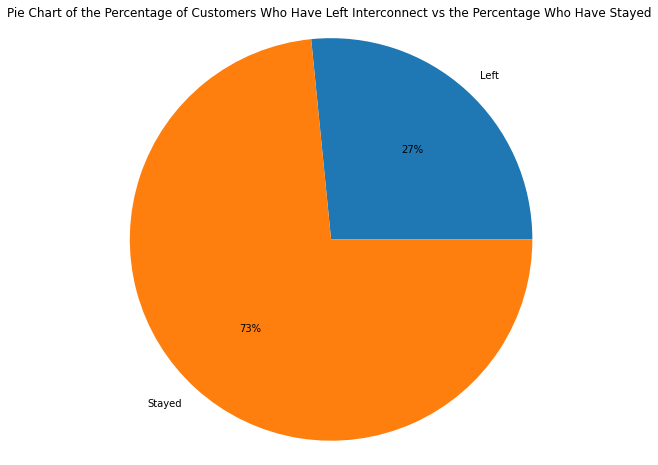

In [73]:
target_sizes = [len(all_info[all_info['left_interconnect'] == 1]) * 100, 
                len(all_info[all_info['left_interconnect'] == 0]) * 100]

target_labels = ['Left', 'Stayed']

plt.figure(figsize = (8, 8))

plt.pie(target_sizes, labels = target_labels, autopct = lambda p:'{:.0f}%'.format(round(p)))
plt.axis('equal')

plt.title('Pie Chart of the Percentage of Customers Who Have Left Interconnect vs the Percentage Who Have Stayed')
plt.show()

There is indeed an imbalance, as there are far more customers who have stayed with Interconnect (73%) than customers who have left (27%). I won't do anything about this yet, but later when I begin building machine learning models I will experiment with upsampling and, if needed, downsampling as well. 

Now I am interested in exploring if there is any correlation between how much customers are charged on a monthly basis and how long they stayed with Interconnect. It is a good idea to look at the correlation values of those who have left separately from the values of those who have stayed.

In [74]:
all_info_left = all_info[all_info['left_interconnect'] == 1].copy()
all_info_stayed = all_info[all_info['left_interconnect'] == 0].copy()

In [75]:
print('Regarding customers who have left Interconnect, the correlation between their')
print('monthly fee and the number of months they stayed with Interconnect is:', 
      round(all_info_left['monthly_fee'].corr(all_info_left['duration_months']), 2))

print()

print('Furthermore, the correlation between their average monthly fines')
print('and the number of months they stayed with Interconnect is:',
      round(all_info_left['monthly_fines_avg'].corr(all_info_left['duration_months']), 2))

Regarding customers who have left Interconnect, the correlation between their
monthly fee and the number of months they stayed with Interconnect is: 0.4

Furthermore, the correlation between their average monthly fines
and the number of months they stayed with Interconnect is: 0.01


Fascinating! When it comes to customers who have left Interconnect, I would have thought that there is a negative correlation between their monthly fees and how many months they stayed with Interconnect. Intuition tells me that the more a customer must pay each month, the fewer months they will stay with the company, yet, counterintuitvely, there is actually a weak to moderate <u>POSITIVE</u> correlation between these variables. 

Furthermore, for the same reason, I would have expected there to be a negative correlation between their average monthly fines and how many months they stayed with Interconnect, however there is actually absolutely no correlation between these variables.

The above correlation values lead me to think that the reasons why some customers leave Interconnect have little to do with the monthly costs. Maybe instead there is something about the perceived quality of Interconnect's services that make some customers leave.

In [76]:
print('Regarding customers who have stayed with Interconnect, the correlation between')
print('their monthly fee and the number of months they stayed with Interconnect is:', 
      round(all_info_stayed['monthly_fee'].corr(all_info_stayed['duration_months']), 2))

print()

print('Furthermore, the correlation between their average monthly fines')
print('and the number of months they stayed with Interconnect is:',
      round(all_info_stayed['monthly_fines_avg'].corr(all_info_stayed['duration_months']), 2))

Regarding customers who have stayed with Interconnect, the correlation between
their monthly fee and the number of months they stayed with Interconnect is: 0.33

Furthermore, the correlation between their average monthly fines
and the number of months they stayed with Interconnect is: -0.39


I am intrigued by the negative correlation between average monthly fines and number of months stayed with Interconnect among customers who continue to use Interconnect's services. It appears that the longer these customers stay with Interconnect, the less they pay in fines each month. On the one hand, this interpretation makes sense because customers with more experience are less likely to go over their package limits. On the other hand, this interpretation should be taken with a grain of salt because the correlation is at best moderate, and might more accurately be described as "weak".

Regarding customers who have left Interconnect, do they tend to leave quickly or do they tend to leave after a relatively long amount of time?

In [77]:
all_info[all_info['left_interconnect'] == 1]['duration_months'].describe()

count    1869.000000
mean       17.979133
std        19.531123
min         1.000000
25%         2.000000
50%        10.000000
75%        29.000000
max        72.000000
Name: duration_months, dtype: float64

In [78]:
all_info[all_info['left_interconnect'] == 0]['duration_months'].describe()

count    5163.00000
mean       36.65001
std        24.07694
min         0.00000
25%        14.00000
50%        37.00000
75%        60.00000
max        71.00000
Name: duration_months, dtype: float64

It turns out that those who leave Interconnect do tend to do so relatively quickly. The median **duration_months** value of those who left Interconnect is 10, which implies that more than half of those who left Interconnect were customers for less than one year (12 months). 

In contrast, the first quartile **duration_months** value of those who are still Interconnect customers is 14, meaning more than 75% of Interconnect's continuing customers have been with the company for over one year (12 months).

In the next lines I plot a relative frequency bar graph that shows the distribution of **duration_months** values for both those who have left and those who have not. The graph would be too "squished" if I included every **duration_months** value on the x-axis, so I will put the **duration_months** values into groups of 6.

In [79]:
duration_left = pd.DataFrame()
duration_left = all_info[all_info['left_interconnect'] == 1]['duration_months']
duration_left = duration_left.reset_index(drop = True)

duration_left_rf_values = [len(duration_left[(duration_left >= 1) & (duration_left <= 6)]),
                           len(duration_left[(duration_left >= 7) & (duration_left <= 12)]),
                           len(duration_left[(duration_left >= 13) & (duration_left <= 18)]),
                           len(duration_left[(duration_left >= 19) & (duration_left <= 24)]),
                           len(duration_left[(duration_left >= 25) & (duration_left <= 30)]),
                           len(duration_left[(duration_left >= 31) & (duration_left <= 36)]),
                           len(duration_left[(duration_left >= 37) & (duration_left <= 42)]),
                           len(duration_left[(duration_left >= 43) & (duration_left <= 48)]),
                           len(duration_left[(duration_left >= 49) & (duration_left <= 54)]),
                           len(duration_left[(duration_left >= 55) & (duration_left <= 60)]),
                           len(duration_left[(duration_left >= 61) & (duration_left <= 66)]),
                           len(duration_left[(duration_left >= 67) & (duration_left <= 72)])]

duration_left_rf_values = [value / len(duration_left) for value in duration_left_rf_values]

In [80]:
duration_stayed = pd.DataFrame()
duration_stayed = all_info[all_info['left_interconnect'] == 0]['duration_months']
duration_stayed = duration_stayed.reset_index(drop = True)

duration_stayed_rf_values = [len(duration_stayed[(duration_stayed >= 1) & (duration_stayed <= 6)]),
                             len(duration_stayed[(duration_stayed >= 7) & (duration_stayed <= 12)]),
                             len(duration_stayed[(duration_stayed >= 13) & (duration_stayed <= 18)]),
                             len(duration_stayed[(duration_stayed >= 19) & (duration_stayed <= 24)]),
                             len(duration_stayed[(duration_stayed >= 25) & (duration_stayed <= 30)]),
                             len(duration_stayed[(duration_stayed >= 31) & (duration_stayed <= 36)]),
                             len(duration_stayed[(duration_stayed >= 37) & (duration_stayed <= 42)]),
                             len(duration_stayed[(duration_stayed >= 43) & (duration_stayed <= 48)]),
                             len(duration_stayed[(duration_stayed >= 49) & (duration_stayed <= 54)]),
                             len(duration_stayed[(duration_stayed >= 55) & (duration_stayed <= 60)]),
                             len(duration_stayed[(duration_stayed >= 61) & (duration_stayed <= 66)]),
                             len(duration_stayed[(duration_stayed >= 67) & (duration_stayed <= 72)])]

duration_stayed_rf_values = [value / len(duration_left) for value in duration_stayed_rf_values]

In [81]:
duration_left_rf_series = pd.Series(duration_left_rf_values)
duration_stayed_rf_series = pd.Series(duration_stayed_rf_values)

duration_rf_series_merged = pd.concat([duration_left_rf_series, duration_stayed_rf_series], axis = 'columns')
duration_rf_series_merged.columns = ['duration_left_rf', 'duration_stayed_rf']

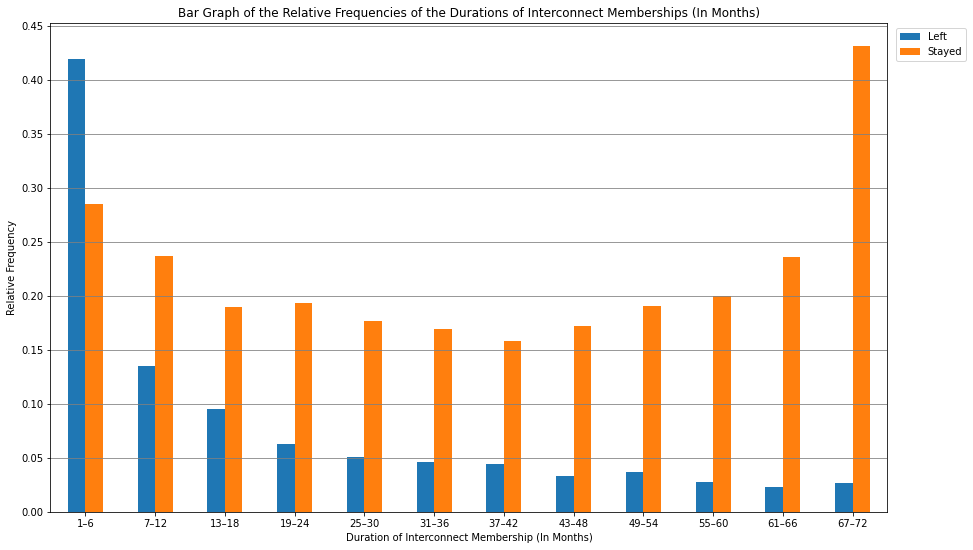

In [82]:
duration_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Duration of Interconnect Membership (In Months)',
                title = 'Bar Graph of the Relative Frequencies of the Durations of Interconnect Memberships (In Months)',
                ylabel = 'Relative Frequency', y = ['duration_left_rf', 'duration_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(12)
xticks_labels = ['1–6', '7–12', '13–18', '19–24', '25–30', '31–36', '37–42', '43–48', '49–54', '55–60', '61–66', '67–72']
plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 0.5, step = 0.05))
plt.show()

As expected, the distribution of the durations of the memberships of the customers who have left starts high then decreases dramatically.

I wonder what percentage of Interconnect customers use each **contract_type**?

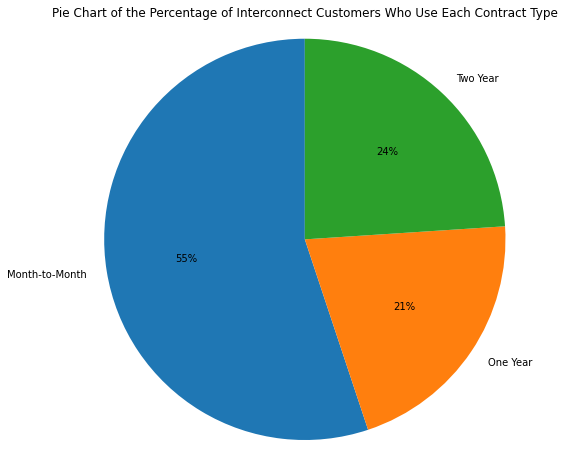

In [83]:
contract_type_sizes = [len(all_info[all_info['contract_type'] == 0]) * 100, 
                       len(all_info[all_info['contract_type'] == 1]) * 100,
                       len(all_info[all_info['contract_type'] == 2]) * 100,]

contract_type_labels = ['Month-to-Month', 'One Year', 'Two Year']

plt.figure(figsize = (8, 8))

plt.pie(contract_type_sizes, labels = contract_type_labels, autopct = lambda p:'{:.0f}%'.format(round(p)), startangle = 90)
plt.axis('equal')

plt.title('Pie Chart of the Percentage of Interconnect Customers Who Use Each Contract Type')
plt.show()

**Month-to-month** contracts are, hands down, the most popular contract type chosen by Interconnect customers, with over 50% of them choosing this option. Interestingly, **one-year** and **two-year** contracts are approximately equally common.

I wonder if customers with **month-to-month** contracts are the most likely to leave. I suspect that this is true because this contract type is, by far, the shortest in length and hence the easiest one to not renew. A relative frequency bar graph is appropriate for this investigation.

In [84]:
contract_type_left = pd.DataFrame()
contract_type_left = all_info[all_info['left_interconnect'] == 1]['contract_type']
contract_type_left = contract_type_left.reset_index(drop = True)

contract_type_left_rf_values = [len(contract_type_left[contract_type_left == 0]), 
                                len(contract_type_left[contract_type_left == 1]),
                                len(contract_type_left[contract_type_left == 2])]

contract_type_left_rf_values = [value / len(contract_type_left) for value in contract_type_left_rf_values]

In [85]:
contract_type_stayed = pd.DataFrame()
contract_type_stayed = all_info[all_info['left_interconnect'] == 0]['contract_type']
contract_type_stayed = contract_type_stayed.reset_index(drop = True)

contract_type_stayed_rf_values = [len(contract_type_stayed[contract_type_stayed == 0]), 
                                  len(contract_type_stayed[contract_type_stayed == 1]),
                                  len(contract_type_stayed[contract_type_stayed == 2])]

contract_type_stayed_rf_values = [value / len(contract_type_stayed) for value in contract_type_stayed_rf_values]

In [86]:
contract_type_left_rf_series = pd.Series(contract_type_left_rf_values)
contract_type_stayed_rf_series = pd.Series(contract_type_stayed_rf_values)

contract_type_rf_series_merged = pd.concat([contract_type_left_rf_series, contract_type_stayed_rf_series], axis = 'columns')
contract_type_rf_series_merged.columns = ['contract_type_left_rf', 'contract_type_stayed_rf']

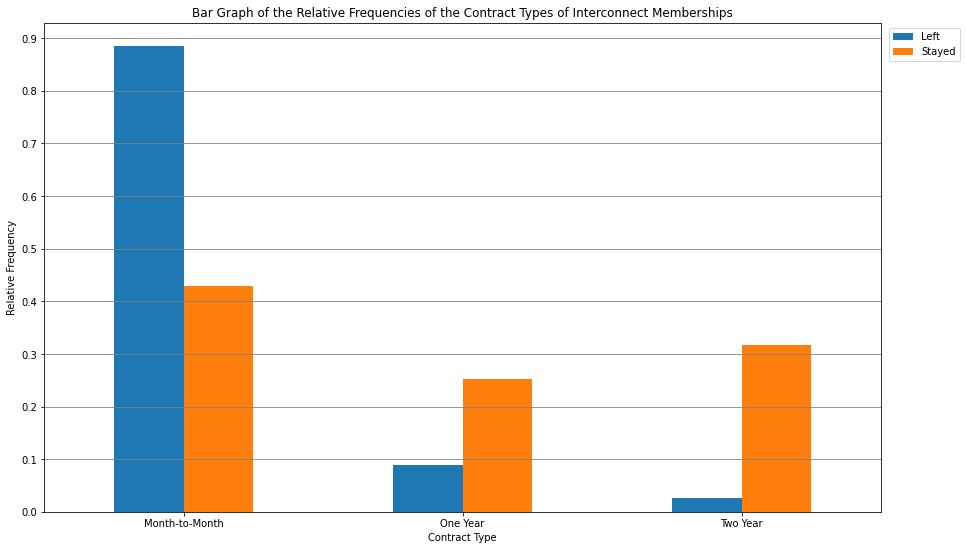

In [87]:
contract_type_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Contract Type',
            title = 'Bar Graph of the Relative Frequencies of the Contract Types of Interconnect Memberships',
            ylabel = 'Relative Frequency', y = ['contract_type_left_rf', 'contract_type_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(3)
xticks_labels = ['Month-to-Month', 'One Year', 'Two Year']
plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 1, step = 0.1))
plt.show()

Wow! Indeed, customers with **month-to-month** contracts are the most likely to leave, as evidenced by how nearly 90% of Interconnect customers who have left had a **month-to-month** contract. 

This is a very useful find for Interconnect stakeholders, as it gives a major insight about customers who leave. Perhaps Interconnect should stop offering month-to-month contracts as a way to reduce the number of customers who leave, or at the very least keep them around for longer. Maybe month-to-month contracts should be replaced with six-month contracts.

Now I wonder what percentage of Interconnect customers use each **payment_method**?

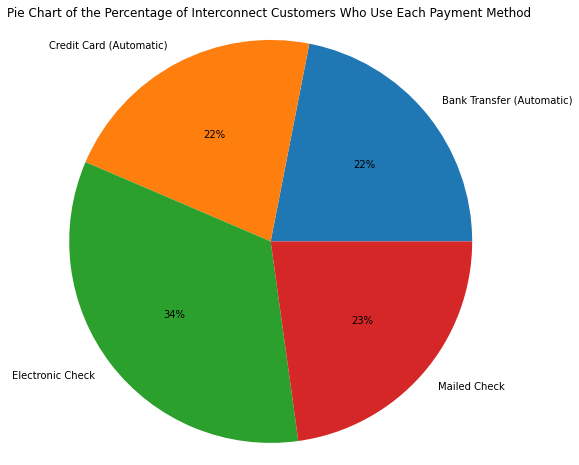

In [88]:
payment_method_sizes = [len(all_info[all_info['payment_method'] == 0]) * 100, 
                        len(all_info[all_info['payment_method'] == 1]) * 100,
                        len(all_info[all_info['payment_method'] == 2]) * 100,
                        len(all_info[all_info['payment_method'] == 3]) * 100]

payment_method_labels = ['Bank Transfer (Automatic)', 'Credit Card (Automatic)', 'Electronic Check', 'Mailed Check']

plt.figure(figsize = (8, 8))

plt.pie(payment_method_sizes, labels = payment_method_labels, autopct = lambda p:'{:.0f}%'.format(round(p)))
plt.axis('equal')

plt.title('Pie Chart of the Percentage of Interconnect Customers Who Use Each Payment Method')
plt.show()

Interesting! **Electronic check** is the most common payment method, being used by about 1/3 of Interconnect customers. Furthermore, the remaining three methods are approximately equally common.

I wonder if certain payment methods are more likely to correspond with customers leaving than others. In particular, I suspect that customers who pay with either an electronic check or a mailed check are more likely to leave than customers who use an automatic payment method. 

I suspect this might be true because customers who use a check are likely to be more cognizant of how much they are spending on Interconnect's services, and therefore might be more likely to leave.

A relative frequency bar graph is appropriate for this investigation.

In [89]:
payment_method_left = pd.DataFrame()
payment_method_left = all_info[all_info['left_interconnect'] == 1]['payment_method']
payment_method_left = payment_method_left.reset_index(drop = True)

payment_method_left_rf_values = [len(payment_method_left[payment_method_left == 0]), 
                                 len(payment_method_left[payment_method_left == 1]),
                                 len(payment_method_left[payment_method_left == 2]),
                                 len(payment_method_left[payment_method_left == 3])]

payment_method_left_rf_values = [value / len(payment_method_left) for value in payment_method_left_rf_values]

In [90]:
payment_method_stayed = pd.DataFrame()
payment_method_stayed = all_info[all_info['left_interconnect'] == 0]['payment_method']
payment_method_stayed = payment_method_stayed.reset_index(drop = True)

payment_method_stayed_rf_values = [len(payment_method_stayed[payment_method_stayed == 0]), 
                                   len(payment_method_stayed[payment_method_stayed == 1]),
                                   len(payment_method_stayed[payment_method_stayed == 2]),
                                   len(payment_method_stayed[payment_method_stayed == 3])]

payment_method_stayed_rf_values = [value / len(payment_method_stayed) for value in payment_method_stayed_rf_values]

In [91]:
payment_method_left_rf_series = pd.Series(payment_method_left_rf_values)
payment_method_stayed_rf_series = pd.Series(payment_method_stayed_rf_values)

payment_method_rf_series_merged = pd.concat([payment_method_left_rf_series, payment_method_stayed_rf_series], 
                                            axis = 'columns')

payment_method_rf_series_merged.columns = ['payment_method_left_rf', 'payment_method_stayed_rf']

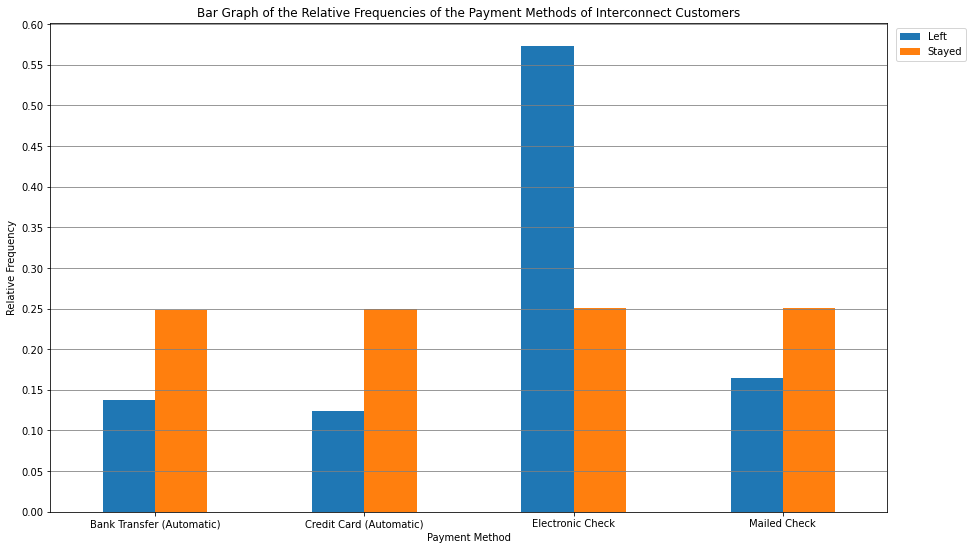

In [92]:
payment_method_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Payment Method',
            title = 'Bar Graph of the Relative Frequencies of the Payment Methods of Interconnect Customers',
            ylabel = 'Relative Frequency', y = ['payment_method_left_rf', 'payment_method_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(4)
xticks_labels = ['Bank Transfer (Automatic)', 'Credit Card (Automatic)', 'Electronic Check', 'Mailed Check']
plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 0.65, step = 0.05))
plt.show()

Fascinating! I suspected that customers who paid with a check were more likely to leave than customers who paid using an automatic method, and this appears to be true for customers who paid using an electronic check but not true for customers who paid using a mailed check.

Furthermore, recall that in the pie chart of all customers (both those who have left and those who have stayed) 34% of them paid using an electronic check, which is the most common method, and yet when looking at only the customers who have stayed, all four payment methods are virtually equally common. Hence, the 34% turns out to be caused by the disproportionately high number of customers who left who used this payment method (>55% of them).

Honestly, I can't think of a reason why the electronic check method is so disproportionately prevalent among those who have left, but this is an intriguing observation nevertheless.

I wonder if there is any relationship between the type of internet service a customer has, if any, and how likely they are to stay. This is yet another investigation where making a relative frequency bar graph is appropriate.

In [93]:
internet_usage_left = pd.DataFrame()
internet_usage_left = all_info[all_info['left_interconnect'] == 1]['internet_service']
internet_usage_left = internet_usage_left.reset_index(drop = True)

internet_usage_left_rf_values = [len(internet_usage_left[internet_usage_left == -1]), 
                                 len(internet_usage_left[internet_usage_left == 0]),
                                 len(internet_usage_left[internet_usage_left == 1])]

internet_usage_left_rf_values = [value / len(internet_usage_left) for value in internet_usage_left_rf_values]

In [94]:
internet_usage_stayed = pd.DataFrame()
internet_usage_stayed = all_info[all_info['left_interconnect'] == 0]['internet_service']
internet_usage_stayed = internet_usage_stayed.reset_index(drop = True)

internet_usage_stayed_rf_values = [len(internet_usage_stayed[internet_usage_stayed == -1]), 
                                   len(internet_usage_stayed[internet_usage_stayed == 0]),
                                   len(internet_usage_stayed[internet_usage_stayed == 1])]

internet_usage_stayed_rf_values = [value / len(internet_usage_stayed) for value in internet_usage_stayed_rf_values]

In [95]:
internet_usage_left_rf_series = pd.Series(internet_usage_left_rf_values)
internet_usage_stayed_rf_series = pd.Series(internet_usage_stayed_rf_values)

internet_usage_rf_series_merged = pd.concat([internet_usage_left_rf_series, internet_usage_stayed_rf_series], 
                                            axis = 'columns')

internet_usage_rf_series_merged.columns = ['internet_usage_left_rf', 'internet_usage_stayed_rf']

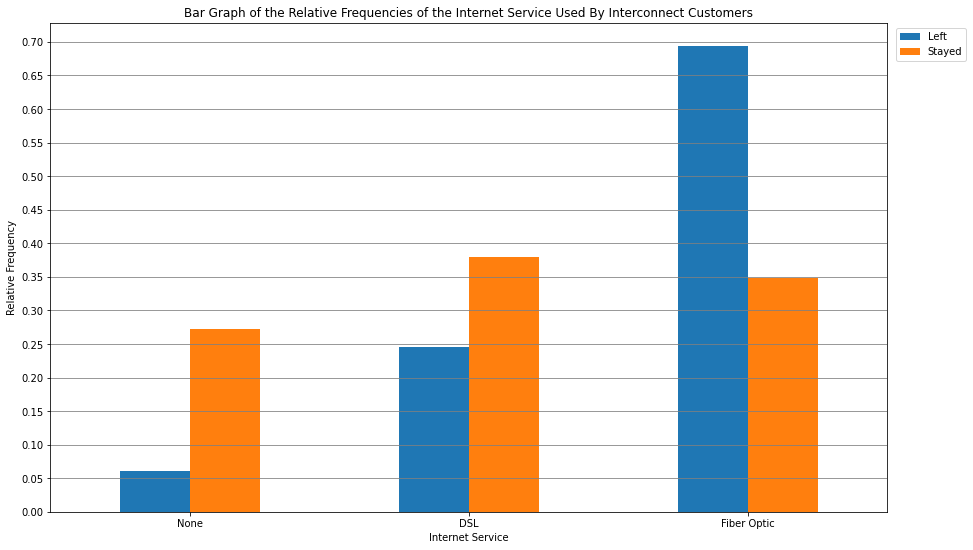

In [96]:
internet_usage_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Internet Service',
            title = 'Bar Graph of the Relative Frequencies of the Internet Service Used By Interconnect Customers',
            ylabel = 'Relative Frequency', y = ['internet_usage_left_rf', 'internet_usage_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(3)
xticks_labels = ['None', 'DSL', 'Fiber Optic']
plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 0.75, step = 0.05))
plt.show()

Wow! Nearly 70% of customers who left Interconnect used the **fiber optic** internet service. I doubt this is due to random chance, rather I suspect that these customers were dissatisfied by the quality of the **fiber optic** internet service. A common complaint from people who were dissatisfied by their internet service is that they perceived their internet speed as being too slow. I encourage Interconnect stakeholders to conduct a survey to help them find out if this is the reason why some people left Interconnect, and/or if there are other reasons that pertain to Interconnect's internet services.

What about Interconnect's phone services? Do customers with one particular phone service leave more often than those with another phone service?

In [97]:
phone_lines_left = pd.DataFrame()
phone_lines_left = all_info[all_info['left_interconnect'] == 1]['multiple_lines']
phone_lines_left = phone_lines_left.reset_index(drop = True)

phone_lines_left_rf_values = [len(phone_lines_left[phone_lines_left == -1]), 
                              len(phone_lines_left[phone_lines_left == 0]),
                              len(phone_lines_left[phone_lines_left == 1])]

phone_lines_left_rf_values = [value / len(phone_lines_left) for value in phone_lines_left_rf_values]

In [98]:
phone_lines_stayed = pd.DataFrame()
phone_lines_stayed = all_info[all_info['left_interconnect'] == 0]['multiple_lines']
phone_lines_stayed = phone_lines_stayed.reset_index(drop = True)

phone_lines_stayed_rf_values = [len(phone_lines_stayed[phone_lines_stayed == -1]), 
                                len(phone_lines_stayed[phone_lines_stayed == 0]),
                                len(phone_lines_stayed[phone_lines_stayed == 1])]

phone_lines_stayed_rf_values = [value / len(phone_lines_stayed) for value in phone_lines_stayed_rf_values]

In [99]:
phone_lines_left_rf_series = pd.Series(phone_lines_left_rf_values)
phone_lines_stayed_rf_series = pd.Series(phone_lines_stayed_rf_values)

phone_lines_rf_series_merged = pd.concat([phone_lines_left_rf_series, phone_lines_stayed_rf_series], axis = 'columns')

phone_lines_rf_series_merged.columns = ['phone_lines_left_rf', 'phone_lines_stayed_rf']

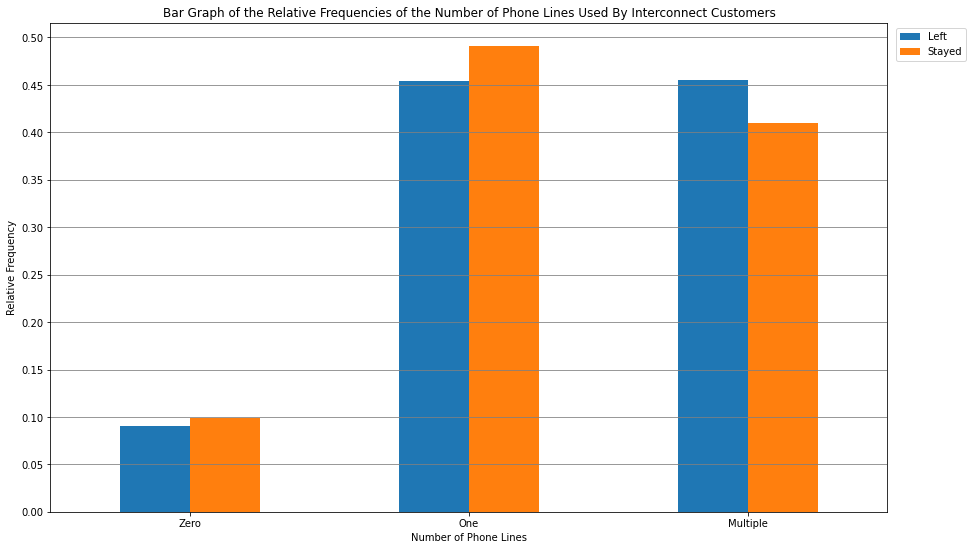

In [100]:
phone_lines_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Number of Phone Lines',
            title = 'Bar Graph of the Relative Frequencies of the Number of Phone Lines Used By Interconnect Customers',
            ylabel = 'Relative Frequency', y = ['phone_lines_left_rf', 'phone_lines_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(3)
xticks_labels = ['Zero', 'One', 'Multiple']
plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 0.55, step = 0.05))
plt.show()

Regarding customers who left Interconnect, about 45% of them had one phone line and about 45% had multiple. Unfortunately, this graph does not give me any insights. I already knew that the majority of both former and current customers have at least one phone line, and there is no evidence that the number of phone lines is predictive of whether or not a customer will leave Interconnect. 

There is one last variable relationship I wish to explore: Does having a partner and/or dependents make a person more likely to stay with Interconnect? The answer might be "yes" because one can argue that a customer would want to keep their membership in order to provide for their partner and/or dependents. However, the answer might be "no" because the more people there are on a plan, the less affordable the plan is. 

Let's make one last relative frequency bar graph.

In [101]:
partner_dependents_left = pd.DataFrame()
partner_dependents_left = all_info[all_info['left_interconnect'] == 1][['dependents', 'partner']]
partner_dependents_left = partner_dependents_left.reset_index(drop = True)

partner_dependents_left_rf_values = [len(partner_dependents_left[(partner_dependents_left['dependents'] == 1) 
                                                                 & (partner_dependents_left['partner'] == 1)]),
                                     
                                     len(partner_dependents_left[(partner_dependents_left['dependents'] == 1) 
                                                                 & (partner_dependents_left['partner'] == 0)]),
                                     
                                     len(partner_dependents_left[(partner_dependents_left['dependents'] == 0) 
                                                                 & (partner_dependents_left['partner'] == 1)]), 
                                     
                                     len(partner_dependents_left[(partner_dependents_left['dependents'] == 0) 
                                                                 & (partner_dependents_left['partner'] == 0)])] 


partner_dependents_left_rf_values = [value / len(partner_dependents_left) for value in partner_dependents_left_rf_values]

In [102]:
partner_dependents_stayed = pd.DataFrame()
partner_dependents_stayed = all_info[all_info['left_interconnect'] == 0][['dependents', 'partner']]
partner_dependents_stayed = partner_dependents_stayed.reset_index(drop = True)

partner_dependents_stayed_rf_values = [len(partner_dependents_stayed[(partner_dependents_stayed['dependents'] == 1) 
                                                                     & (partner_dependents_stayed['partner'] == 1)]),
                                     
                                       len(partner_dependents_stayed[(partner_dependents_stayed['dependents'] == 1) 
                                                                 & (partner_dependents_stayed['partner'] == 0)]),
                                     
                                       len(partner_dependents_stayed[(partner_dependents_stayed['dependents'] == 0) 
                                                                 & (partner_dependents_stayed['partner'] == 1)]), 
                                     
                                       len(partner_dependents_stayed[(partner_dependents_stayed['dependents'] == 0) 
                                                                 & (partner_dependents_stayed['partner'] == 0)])] 


partner_dependents_stayed_rf_values = [num / len(partner_dependents_stayed) for num in partner_dependents_stayed_rf_values]

In [103]:
partner_dependents_left_rf_series = pd.Series(partner_dependents_left_rf_values)
partner_dependents_stayed_rf_series = pd.Series(partner_dependents_stayed_rf_values)

partner_dependents_rf_series_merged = pd.concat([partner_dependents_left_rf_series, partner_dependents_stayed_rf_series], 
                                                axis = 'columns')

partner_dependents_rf_series_merged.columns = ['partner_dependents_left_rf', 'partner_dependents_stayed_rf']

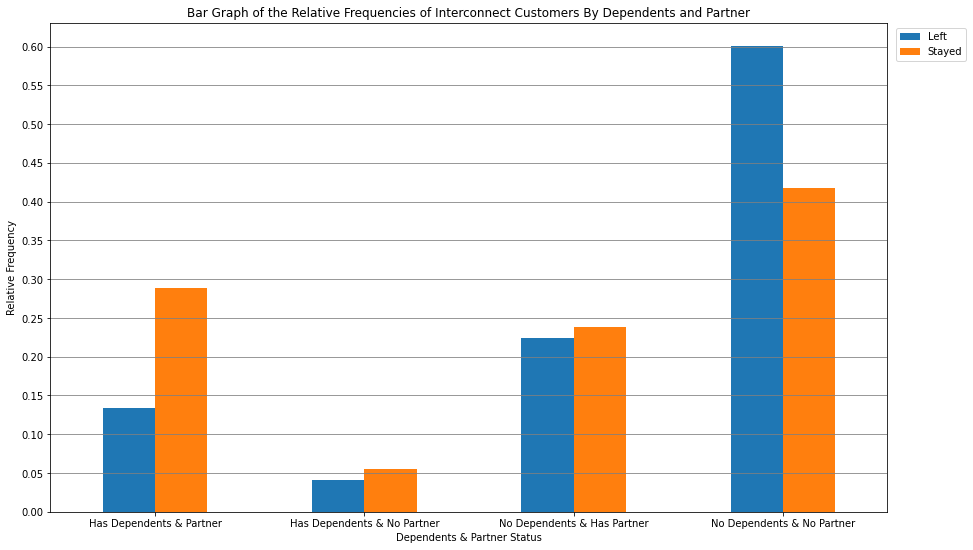

In [104]:
partner_dependents_rf_series_merged.plot(kind = 'bar', figsize = (15, 9), xlabel = 'Dependents & Partner Status',
            title = 'Bar Graph of the Relative Frequencies of Interconnect Customers By Dependents and Partner',
            ylabel = 'Relative Frequency', y = ['partner_dependents_left_rf', 'partner_dependents_stayed_rf'])

plt.grid(axis = 'y', color = 'gray')
plt.legend(['Left', 'Stayed'], bbox_to_anchor = (1.1, 1.0), loc = 'upper right')

xticks_positions = np.arange(4)
xticks_labels = ['Has Dependents & Partner', 'Has Dependents & No Partner', 
                 'No Dependents & Has Partner', 'No Dependents & No Partner']

plt.xticks(xticks_positions, xticks_labels, rotation = 0)

plt.yticks(np.arange(0, 0.65, step = 0.05))
plt.show()

Regarding customers who have left Interconnect, about 60% of them have no dependent and no partner. This makes a lot of sense, because if a person was dissatisfied by the services of a company they were a member of to the point they wanted to switch to a different company, then it'd be much easier to do so if they were on their own than if they had anyone else in their household.

In contrast, less than 15% of customers who have left Interconnect have dependents and a partner. Furthermore, of the customers who are still with Interconnect, more than 25% of them belong to this category. I perceive this as evidence that supports my hunch that customers with dependents and a partner would be hesitant to leave their Interconnect membership because it is not convenient to make a switch when multiple people would be affected by it.

# Work Plan and Questions <a id = 7></a>

Now that I have done data preprocessing, features engineering, and EDA, I am ready to write my work plan: 

(1) Get answers to the questions I have (see below) in order to find out if I need to do any more features engineering and/or EDA.

(2) Use the majority of the columns in the **all_info** dataframe to build binary classification machine learning models, with the **left_interconnect** column being the target. I have been informed that boosting algorithms (e.g. CatBoost, LightGBM, XGB, etc.) are likely to be especially useful for this task.

(3) Ideally, the AUC-ROC value of the model will be at least 0.85 (the closer to 1 the better). Hyperparameter tuning might help increase the AUC-ROC value.

(4) Write a report to Interconnect stakeholders about my findings made throughout this project.

The following are my clarifying questions for my team leader:

(I) Do you think I made the right call by dropping the information from the **internet_info** dataframe in **all_info**? Or is there a way for me to include that information without there being any ambiguity about which customers correspond to the information?

(II) Is there any more features engineering you think I should do?

(III) Is there any more EDA you think I should do? I wonder if there are any correlations and/or other relationships between the variables I should explore?

(IV) Any advice on how to build a good machine learning model for this task (aside from "use a boosting algorithm")? I wonder if there are any particular hyperparameters that should be tuned in a specific way.

# Solution Code <a id = 8></a>

**Training, Validation, and Test Sets** <a id = 8.1></a>

I will use the following (commonly used) ratio for splitting the dataset into training, validation, and test sets: 60/20/20.

In [105]:
_, test_set = train_test_split(all_info, test_size = 0.2, random_state = 7, stratify = all_info['left_interconnect'])

test_features = test_set.drop(['customer_id', 'left_interconnect', 'begin_date', 'end_date'], axis = 1)
test_target = test_set['left_interconnect']

In [106]:
all_info_not_test = all_info.drop(test_features.index)

train_set, valid_set = train_test_split(all_info_not_test, test_size = 0.25, random_state = 7, 
                                        stratify = all_info_not_test['left_interconnect'])

train_features = train_set.drop(['customer_id', 'left_interconnect', 'begin_date', 'end_date'], axis = 1)
train_target = train_set['left_interconnect']

valid_features = valid_set.drop(['customer_id', 'left_interconnect', 'begin_date', 'end_date'], axis = 1)
valid_target = valid_set['left_interconnect']

In [107]:
print('Size of the training set:')
print('Features =', train_features.shape)
print('Target =', train_target.shape)
print()
print('Size of the validation set:')
print('Features =', valid_features.shape)
print('Target =', valid_target.shape)
print()
print('Size of the test set:')
print('Features =', test_features.shape)
print('Target =', test_target.shape)

Size of the training set:
Features = (4218, 21)
Target = (4218,)

Size of the validation set:
Features = (1407, 21)
Target = (1407,)

Size of the test set:
Features = (1407, 21)
Target = (1407,)


**Upsampling & Downsampling Functions** <a id = 8.2></a>

The following is an explanation of how the upsampling function works:

1) It first splits the training sample into positive and negative observations.

2) It then duplicates the positive observations a designated number of times.

3) Next, it creates a new training sample based on the data obtained.

4) Lastly, it shuffles the data

In [108]:
def upsample(features, target, repeat):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)

    features_upsampled, target_upsampled = shuffle(features_upsampled, target_upsampled, random_state = 7)

    return features_upsampled, target_upsampled

In [109]:
train_features_upsampled, train_target_upsampled = upsample(train_features, train_target, 3)

display(train_target_upsampled.value_counts())

1    3363
0    3097
Name: left_interconnect, dtype: int64

Great! By upsampling the training set, I now have a ratio between the two possible target values that is much closer to 1:1! 

This improved ratio should help the models significantly.

As for downsampling, that is done by following these steps:

1) Splitting the training sample into positive and negative observations.

2) Randomly dropping a portion of the negative observations.

3) Creating a new training sample based on the data obtained.

4) Shuffling the data.

In [110]:
def downsample(features, target, fraction):
    
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat([features_zeros.sample(frac = fraction, random_state = 7)] + [features_ones])
    target_downsampled = pd.concat([target_zeros.sample(frac = fraction, random_state = 7)] + [target_ones])

    features_downsampled, target_downsampled = shuffle(features_downsampled, target_downsampled, random_state = 7)

    return features_downsampled, target_downsampled

In [111]:
train_features_downsampled, train_target_downsampled = downsample(train_features, train_target, 0.362)

display(train_target_downsampled.value_counts())

0    1121
1    1121
Name: left_interconnect, dtype: int64

Wonderful! This downsampled training set has an equal number of each possible target value! Needless to say, there is absolutely no class imbalance.

Just in case the upsampled training set does not result in a sufficiently large AUC-ROC value, then maybe the downsampled training set will.

**Dummy Classifier – Upsampled** <a id = 8.3></a>

It is a great idea to build a dummy classifier model because it can be used to sanity check the other models.

I will set the **strategy** parameter equal to **uniform** (meaning the model makes predictions uniformly at random).

In [112]:
dummy_upsampled = DummyClassifier(strategy = 'uniform')
dummy_upsampled.fit(train_features_upsampled, train_target_upsampled)

DummyClassifier(strategy='uniform')

In [113]:
dummy_upsampled_valid_pred_proba = dummy_upsampled.predict_proba(valid_features)
dummy_upsampled_valid_pred_proba = dummy_upsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, dummy_upsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.5


As expected, the dummy classifier acquires an AUC-ROC value of 0.5, just like random guessing.

**Dummy Classifier – Downsampled** <a id = 8.4></a>

In [114]:
dummy_downsampled = DummyClassifier(strategy = 'uniform')
dummy_downsampled.fit(train_features_downsampled, train_target_downsampled)

DummyClassifier(strategy='uniform')

In [115]:
dummy_downsampled_valid_pred_proba = dummy_downsampled.predict_proba(valid_features)
dummy_downsampled_valid_pred_proba = dummy_downsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, dummy_downsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.5


**Logistic Regression – Upsampled** <a id = 8.5></a>

Apparently, the best **solver** value is **newton-cg**, according to the **GridSearchCV** I use in the next line. 

I commented out it out because **GridSearchCV** can take a long time to process. I will do this everytime I use **GridSearchCV**.

In [116]:
#hyperparameters_lr_model = {'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga']}


#grid_search_lr_upsampled = GridSearchCV(estimator = LogisticRegression(), scoring = 'roc_auc',
#                                        param_grid = hyperparameters_lr_model)

#grid_search_lr_upsampled.fit(train_features_upsampled, train_target_upsampled)

#print(grid_search_lr_upsampled.best_params_)

In [117]:
lr_upsampled = LogisticRegression(solver = 'newton-cg')

In [118]:
%%time

lr_upsampled.fit(train_features_upsampled, train_target_upsampled)

CPU times: user 1.14 s, sys: 1.93 s, total: 3.08 s
Wall time: 3.07 s


LogisticRegression(solver='newton-cg')

In [119]:
lr_upsampled_valid_pred_proba = lr_upsampled.predict_proba(valid_features)
lr_upsampled_valid_pred_proba = lr_upsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lr_upsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.912


Wow! I was not expecting to get such a good AUC-ROC value so quickly! Furthermore, the wall time of this model is very short, which is a big plus!

I could stop here, but it is good practice to try out different models and see if any of them yield an even better AUC-ROC value.

**Logistic Regression – Downsampled** <a id = 8.6></a>

In [120]:
#grid_search_lr_downsampled = GridSearchCV(estimator = LogisticRegression(), scoring = 'roc_auc',
#                                          param_grid = hyperparameters_lr_model)

#grid_search_lr_downsampled.fit(train_features_downsampled, train_target_downsampled)

#print(grid_search_lr_downsampled.best_params_)

In [121]:
lr_downsampled = LogisticRegression(solver = 'newton-cg')

In [122]:
%%time

lr_downsampled.fit(train_features_downsampled, train_target_downsampled)

CPU times: user 568 ms, sys: 1.1 s, total: 1.67 s
Wall time: 1.69 s


LogisticRegression(solver='newton-cg')

In [123]:
lr_downsampled_valid_pred_proba = lr_downsampled.predict_proba(valid_features)
lr_downsampled_valid_pred_proba = lr_downsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lr_downsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.912


This AUC-ROC value is the same as that of the model trained using the upsampled training set, and its wall time is even shorter!

**LGBMClassifier – Upsampled** <a id = 8.7></a>

In [124]:
lgbm_upsampled = LGBMClassifier(random_state = 7)

In [125]:
%%time

lgbm_upsampled.fit(train_features_upsampled, train_target_upsampled)

CPU times: user 1.11 s, sys: 29.9 ms, total: 1.14 s
Wall time: 1.13 s


LGBMClassifier(random_state=7)

I would like to print the hyperparameter values of the "default" **LGBMClassifier** because this will help me decide what values to experiment with when I use **GridSearchCV**. I will do this with all of the other "default" models as well. 

In [126]:
print(lgbm_upsampled.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 7, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [127]:
lgbm_upsampled_valid_pred_proba = lgbm_upsampled.predict_proba(valid_features)
lgbm_upsampled_valid_pred_proba = lgbm_upsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lgbm_upsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.927


Good! This model has an AUC-ROC value that is even larger than that of the logistic regression! 

I wonder if hyperparameter tuning can help improve the AUC-RUC value even more.

In [128]:
#hyperparameters_lgbm_model = {'learning_rate': [0.01, 0.1, 0.2], 'max_depth': [-1, 5, 10, 15], 
#                              'n_estimators': [50, 100, 150, 200], 'num_leaves': [5, 10, 15, 20, 25, 30]}

#grid_search_lgbm_upsampled = GridSearchCV(estimator = LGBMClassifier(), scoring = 'roc_auc',
#                                          param_grid = hyperparameters_lgbm_model)
                                       
#grid_search_lgbm_upsampled.fit(train_features_upsampled, train_target_upsampled)

#print(grid_search_lgbm_upsampled.best_params_)

In [129]:
lgbm_upsampled_tuned = LGBMClassifier(learning_rate = 0.01, max_depth = 15, n_estimators = 200, num_leaves = 30,
                                      random_state = 7)

In [130]:
%%time

lgbm_upsampled_tuned.fit(train_features_upsampled, train_target_upsampled)

CPU times: user 5.04 s, sys: 20.2 ms, total: 5.06 s
Wall time: 5.09 s


LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=200,
               num_leaves=30, random_state=7)

In [131]:
lgbm_upsampled_tuned_valid_pred_proba = lgbm_upsampled_tuned.predict_proba(valid_features)
lgbm_upsampled_tuned_valid_pred_proba = lgbm_upsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lgbm_upsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.932


This is a small, but appreciated, improvement to the AUC-ROC value.

**LGBMClassifier – Downsampled** <a id = 8.8></a>

In [132]:
lgbm_downsampled = LGBMClassifier(random_state = 7)

In [133]:
%%time

lgbm_downsampled.fit(train_features_downsampled, train_target_downsampled)

CPU times: user 1.91 s, sys: 11.1 ms, total: 1.92 s
Wall time: 1.95 s


LGBMClassifier(random_state=7)

In [134]:
print(lgbm_downsampled.get_params())

{'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 1.0, 'importance_type': 'split', 'learning_rate': 0.1, 'max_depth': -1, 'min_child_samples': 20, 'min_child_weight': 0.001, 'min_split_gain': 0.0, 'n_estimators': 100, 'n_jobs': -1, 'num_leaves': 31, 'objective': None, 'random_state': 7, 'reg_alpha': 0.0, 'reg_lambda': 0.0, 'silent': 'warn', 'subsample': 1.0, 'subsample_for_bin': 200000, 'subsample_freq': 0}


In [135]:
lgbm_downsampled_valid_pred_proba = lgbm_downsampled.predict_proba(valid_features)
lgbm_downsampled_valid_pred_proba = lgbm_downsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lgbm_downsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.921


In [136]:
#grid_search_lgbm_downsampled = GridSearchCV(estimator = LGBMClassifier(), scoring = 'roc_auc',
#                                            param_grid = hyperparameters_lgbm_model)
                                       
#grid_search_lgbm_downsampled.fit(train_features_downsampled, train_target_downsampled)

#print(grid_search_lgbm_downsampled.best_params_)

In [137]:
lgbm_downsampled_tuned = LGBMClassifier(learning_rate = 0.01, max_depth = 15, n_estimators = 200, num_leaves = 15,
                                        random_state = 7)

In [138]:
%%time

lgbm_downsampled_tuned.fit(train_features_downsampled, train_target_downsampled)

CPU times: user 1.95 s, sys: 18.4 ms, total: 1.97 s
Wall time: 1.93 s


LGBMClassifier(learning_rate=0.01, max_depth=15, n_estimators=200,
               num_leaves=15, random_state=7)

In [139]:
lgbm_downsampled_tuned_valid_pred_proba = lgbm_downsampled_tuned.predict_proba(valid_features)
lgbm_downsampled_tuned_valid_pred_proba = lgbm_downsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, lgbm_downsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.929


While these AUC-ROC values are quite good, the model responded better to being trained with the upsampled training set.

**XGBClassifier – Upsampled** <a id = 8.9></a>

In [140]:
xgbc_upsampled = XGBClassifier(random_state = 7)

In [141]:
%%time

xgbc_upsampled.fit(train_features_upsampled, train_target_upsampled)

[20:32:43] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 8.58 s, sys: 40.9 ms, total: 8.62 s
Wall time: 8.71 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [142]:
xgbc_upsampled_valid_pred_proba = xgbc_upsampled.predict_proba(valid_features)
xgbc_upsampled_valid_pred_proba = xgbc_upsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, xgbc_upsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.924


I wonder if this model would benefit from hyperparameter tuning. Only one way to find out!

In [143]:
#hyperparameters_xgbc_model = {'learning_rate': [0.01, 0.1, 0.2, 0.3], 'max_depth': [3, 4, 5, 6, 7], 
#                              'n_estimators': [100, 200, 300, 400, 500]}

#grid_search_xgbc_upsampled = GridSearchCV(estimator = XGBClassifier(), scoring = 'roc_auc',
#                                          param_grid = hyperparameters_xgbc_model)

#grid_search_xgbc_upsampled.fit(train_features_upsampled, train_target_upsampled)

#print(grid_search_xgbc_upsampled.best_params_)

In [144]:
xgbc_upsampled_tuned = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 400, random_state = 7)

In [145]:
%%time

xgbc_upsampled_tuned.fit(train_features_upsampled, train_target_upsampled)

[20:32:51] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 20.1 s, sys: 151 ms, total: 20.3 s
Wall time: 20.7 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [146]:
xgbc_upsampled_tuned_valid_pred_proba = xgbc_upsampled_tuned.predict_proba(valid_features)
xgbc_upsampled_tuned_valid_pred_proba = xgbc_upsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, xgbc_upsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.935


This is a decent improvement, at the cost of a considerably longer wall time. So far, this model is the one with the best AUC-ROC value.

**XGBClassifier – Downsampled** <a id = 8.10></a>

In [147]:
xgbc_downsampled = XGBClassifier(random_state = 7)

In [148]:
%%time

xgbc_downsampled.fit(train_features_downsampled, train_target_downsampled)

[20:33:12] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 3.76 s, sys: 45.9 ms, total: 3.81 s
Wall time: 3.81 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [149]:
xgbc_downsampled_valid_pred_proba = xgbc_downsampled.predict_proba(valid_features)
xgbc_downsampled_valid_pred_proba = xgbc_downsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, xgbc_downsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.917


In [150]:
#grid_search_xgbc_downsampled = GridSearchCV(estimator = XGBClassifier(), scoring = 'roc_auc',
#                                            param_grid = hyperparameters_xgbc_model)

#grid_search_xgbc_downsampled.fit(train_features_downsampled, train_target_downsampled)

#print(grid_search_xgbc_downsampled.best_params_)

In [151]:
xgbc_downsampled_tuned = XGBClassifier(learning_rate = 0.01, max_depth = 3, n_estimators = 400, random_state = 7)

In [152]:
%%time

xgbc_downsampled_tuned.fit(train_features_downsampled, train_target_downsampled)

[20:33:16] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


CPU times: user 15.4 s, sys: 58.2 ms, total: 15.4 s
Wall time: 15.5 s


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=3, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=400, n_jobs=4,
              num_parallel_tree=1, predictor='auto', random_state=7,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [153]:
xgbc_downsampled_tuned_valid_pred_proba = xgbc_downsampled_tuned.predict_proba(valid_features)
xgbc_downsampled_tuned_valid_pred_proba = xgbc_downsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, xgbc_downsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.933


This is a good improvement! However, the tuned model trained using the upsampled training set is a tiny bit better.

**CatBoostClassifier – Upsampled** <a id = 8.11></a>

In [154]:
cat_boost_upsampled = CatBoostClassifier(random_state = 7)

In [155]:
%%time

cat_boost_upsampled.fit(train_features_upsampled, train_target_upsampled, verbose = 100)

Learning rate set to 0.022851
0:	learn: 0.6760343	total: 59.3ms	remaining: 59.2s
100:	learn: 0.2987192	total: 479ms	remaining: 4.26s
200:	learn: 0.2587049	total: 919ms	remaining: 3.65s
300:	learn: 0.2311724	total: 1.34s	remaining: 3.11s
400:	learn: 0.2110093	total: 1.77s	remaining: 2.65s
500:	learn: 0.1921747	total: 2.2s	remaining: 2.19s
600:	learn: 0.1762551	total: 2.63s	remaining: 1.75s
700:	learn: 0.1613780	total: 3.07s	remaining: 1.31s
800:	learn: 0.1481555	total: 3.53s	remaining: 877ms
900:	learn: 0.1362261	total: 3.97s	remaining: 436ms
999:	learn: 0.1265854	total: 4.39s	remaining: 0us
CPU times: user 4.36 s, sys: 14.2 ms, total: 4.38 s
Wall time: 4.65 s


In [156]:
print(cat_boost_upsampled.get_params())

{'random_state': 7}


In [157]:
cat_boost_upsampled_valid_pred_proba = cat_boost_upsampled.predict_proba(valid_features)
cat_boost_upsampled_valid_pred_proba = cat_boost_upsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, cat_boost_upsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.932


This model is very promising! In fact, I would not be surprised if it ends up being the best model after receiving some hyperparameter tuning.

In [158]:
#hyperparameters_cb_model = {'max_depth': [2, 4, 6, 8], 'n_estimators': [200, 300, 400, 500], 'learning_rate': [0.01, 0.1]}

#grid_search_cb_upsampled = GridSearchCV(estimator = CatBoostClassifier(), scoring = 'roc_auc',
#                                        param_grid = hyperparameters_cb_model)

#grid_search_cb_upsampled.fit(train_features_upsampled, train_target_upsampled, verbose = 100)

#print(grid_search_cb_upsampled.best_params_)

In [159]:
cat_boost_upsampled_tuned = CatBoostClassifier(learning_rate = 0.01, max_depth = 6, n_estimators = 400, random_state = 7)

In [160]:
%%time

cat_boost_upsampled_tuned.fit(train_features_upsampled, train_target_upsampled, verbose = 100)

0:	learn: 0.6855855	total: 4.12ms	remaining: 1.64s
100:	learn: 0.3619111	total: 433ms	remaining: 1.28s
200:	learn: 0.3073049	total: 863ms	remaining: 854ms
300:	learn: 0.2831438	total: 1.3s	remaining: 428ms
399:	learn: 0.2646971	total: 1.73s	remaining: 0us
CPU times: user 1.76 s, sys: 495 µs, total: 1.76 s
Wall time: 1.91 s


In [161]:
cat_boost_upsampled_tuned_valid_pred_proba = cat_boost_upsampled_tuned.predict_proba(valid_features)
cat_boost_upsampled_tuned_valid_pred_proba = cat_boost_upsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, cat_boost_upsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.935


Though hyperparameter tuning only improved this model a tiny bit, it is now tied for best AUC-ROC value with the tuned XGBClassifier that was training using the upsampled training set. Furthermore, this model has a considerably shorter wall time than the XGBClassifier.

**CatBoostClassifier – Downsampled** <a id = 8.12></a>

In [162]:
cat_boost_downsampled = CatBoostClassifier(random_state = 7)

In [163]:
%%time

cat_boost_downsampled.fit(train_features_downsampled, train_target_downsampled, verbose = 100)

Learning rate set to 0.014543
0:	learn: 0.6822646	total: 2.85ms	remaining: 2.85s
100:	learn: 0.3337539	total: 304ms	remaining: 2.71s
200:	learn: 0.2880536	total: 599ms	remaining: 2.38s
300:	learn: 0.2619447	total: 895ms	remaining: 2.08s
400:	learn: 0.2427485	total: 1.18s	remaining: 1.76s
500:	learn: 0.2252696	total: 1.47s	remaining: 1.46s
600:	learn: 0.2101341	total: 1.76s	remaining: 1.17s
700:	learn: 0.1979096	total: 2.07s	remaining: 884ms
800:	learn: 0.1867562	total: 2.38s	remaining: 590ms
900:	learn: 0.1762123	total: 2.67s	remaining: 293ms
999:	learn: 0.1658657	total: 2.96s	remaining: 0us
CPU times: user 2.96 s, sys: 10.5 ms, total: 2.97 s
Wall time: 3.17 s


In [164]:
print(cat_boost_downsampled.get_params())

{'random_state': 7}


In [165]:
cat_boost_downsampled_valid_pred_proba = cat_boost_downsampled.predict_proba(valid_features)
cat_boost_downsampled_valid_pred_proba = cat_boost_downsampled_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, cat_boost_downsampled_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.931


This model is even more promising than the CatBoostClassifier trained using the upsampled training set!

In [166]:
#grid_search_cb_downsampled = GridSearchCV(estimator = CatBoostClassifier(), scoring = 'roc_auc',
#                                          param_grid = hyperparameters_cb_model)

#grid_search_cb_downsampled.fit(train_features_downsampled, train_target_downsampled, verbose = 100)

#print(grid_search_cb_downsampled.best_params_)

In [167]:
cat_boost_downsampled_tuned = CatBoostClassifier(learning_rate = 0.01, max_depth = 6, n_estimators = 400, random_state = 7)

In [168]:
%%time

cat_boost_downsampled_tuned.fit(train_features_downsampled, train_target_downsampled, verbose = 25)

0:	learn: 0.6856372	total: 2.77ms	remaining: 1.11s
25:	learn: 0.5332799	total: 83.5ms	remaining: 1.2s
50:	learn: 0.4491271	total: 158ms	remaining: 1.08s
75:	learn: 0.3994364	total: 222ms	remaining: 946ms
100:	learn: 0.3688253	total: 298ms	remaining: 883ms
125:	learn: 0.3472239	total: 373ms	remaining: 811ms
150:	learn: 0.3312767	total: 454ms	remaining: 748ms
175:	learn: 0.3204630	total: 527ms	remaining: 670ms
200:	learn: 0.3115900	total: 596ms	remaining: 590ms
225:	learn: 0.3039507	total: 667ms	remaining: 514ms
250:	learn: 0.2966064	total: 740ms	remaining: 439ms
275:	learn: 0.2907793	total: 817ms	remaining: 367ms
300:	learn: 0.2858949	total: 887ms	remaining: 292ms
325:	learn: 0.2806240	total: 963ms	remaining: 219ms
350:	learn: 0.2760981	total: 1.04s	remaining: 146ms
375:	learn: 0.2724966	total: 1.12s	remaining: 71.2ms
399:	learn: 0.2680483	total: 1.18s	remaining: 0us
CPU times: user 1.18 s, sys: 10.4 ms, total: 1.19 s
Wall time: 1.35 s


In [169]:
cat_boost_downsampled_tuned_valid_pred_proba = cat_boost_downsampled_tuned.predict_proba(valid_features)
cat_boost_downsampled_tuned_valid_pred_proba = cat_boost_downsampled_tuned_valid_pred_proba[:, 1]

print('Validation Set AUC-ROC Value =', round(roc_auc_score(valid_target, cat_boost_downsampled_tuned_valid_pred_proba), 3))

Validation Set AUC-ROC Value = 0.933


Though this model has potential, hyperparameter tuning, unfortunately, does not improve it as much as the model trained using the upsampled training set.

# Model Testing <a id = 9></a>

I have decided to pick the model named **cat_boost_upsampled_tuned**. This model is the one that strikes the balance between having a large AUC-ROC value and also having a very short wall time. Let's see if it is able to get a sufficiently large AUC-ROC value on the test set.

In [170]:
cat_boost_upsampled_tuned_test_pred_proba = cat_boost_upsampled_tuned.predict_proba(test_features)
cat_boost_upsampled_tuned_test_pred_proba = cat_boost_upsampled_tuned_test_pred_proba[:, 1]

print('Test Set AUC-ROC Value =', round(roc_auc_score(test_target, cat_boost_upsampled_tuned_test_pred_proba), 3))

Test Set AUC-ROC Value = 0.947


Excellent! I have successfully built a machine learning model that acquired an AUC-ROC value that is at least (and in fact, well over) 0.85 on both the validation set and the test set.

I would like to plot the ROC curve of the validation set and that of the test set so that Interconnect stakeholders may have visuals of my find.

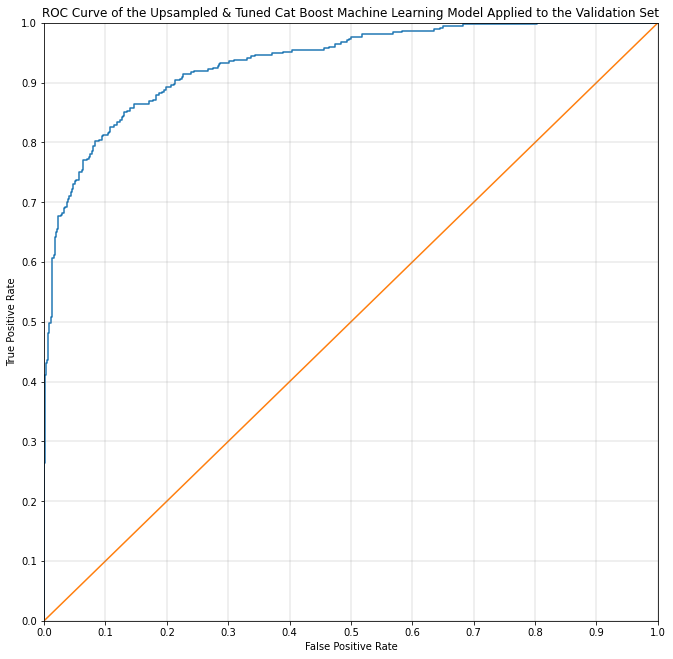

In [171]:
fpr_valid, tpr_valid, thresholds_valid = roc_curve(valid_target, cat_boost_upsampled_tuned_valid_pred_proba)

plt.figure(figsize = (11, 11))
plt.plot(fpr_valid, tpr_valid)
plt.plot([0, 1], [0, 1], linestyle = '-')
plt.title('ROC Curve of the Upsampled & Tuned Cat Boost Machine Learning Model Applied to the Validation Set')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

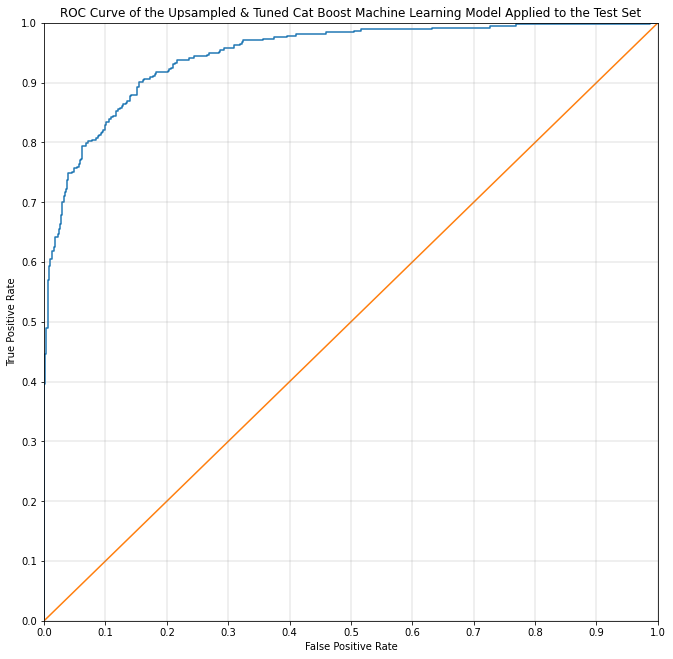

In [172]:
fpr_test, tpr_test, thresholds_test = roc_curve(test_target, cat_boost_upsampled_tuned_test_pred_proba)

plt.figure(figsize = (11, 11))
plt.plot(fpr_test, tpr_test)
plt.plot([0, 1], [0, 1], linestyle = '-')
plt.title('ROC Curve of the Upsampled & Tuned Cat Boost Machine Learning Model Applied to the Test Set')
plt.xlabel('False Positive Rate')
plt.xlim([0.0, 1.0])
plt.xticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
plt.ylabel('True Positive Rate')
plt.ylim([0.0, 1.0])
plt.yticks([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])

for xtick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axvline(x = xtick_value, color = 'grey', linestyle = '-', lw = 0.25)
    
for ytick_value in [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    plt.axhline(y = ytick_value, color = 'grey', linestyle = '-', lw = 0.25)

plt.show()

One of the reasons why ROC curves are useful is because they are a convenient way to give a machine learning model a sanity check.

Hypothetically, if the AUC-ROC value is exactly 0.5, that would mean the model is no better at classifying outcomes than random chance. Furthermore, if the AUC-ROC value is less than 0.5, that would mean the model is even worse at classifying than random chance. 

Since I got an AUC-ROC value that is much closer to 1 than it is to 0.5, I may be confident that my model is much better at classifying than random chance.

It is worth mentioning how promising the thresholds on the ROC curves are. Both curves have a point located at approximately (0.2, 0.9) [though it is more like (0.15, 0.9) for the test set], which means that about 20% (15%) of customers who have not left Interconnect were mistakingly classified as having left (false positives), and about 90% of customers who did leave Interconnect were correctly classified as having left (true positives).

If Interconnect stakeholders happen to conclude that 90% is not a high enough percentage for the true positives, and they would prefer 95% even though this would increase the percentage of false positives, then another approximate point on the ROC curve is (0.4, 0.95) [more like (0.3, 0.95) for the test set].

# Solution Report <a id = 10></a>

My team leader would like for me to answer the following questions: 

(1) What steps of the plan were performed and what steps were skipped (explain why)?

(2) What difficulties did you encounter and how did you manage to solve them?

(3) What were some of the key steps to solving the task?

(4) What is your final model and what quality score does it have?

Furthermore, it would be good to comment on what I think are some of the main reasons why some customers churn.

I will respond to these questions one at a time.

(1) What steps of the plan were performed and what steps were skipped (explain why)?

I performed all of the steps of my work plan. I acquired answers to the questions I had from either my team leader or my code reviewer. Furthermore, I used all of the <u>numerical</u> columns in the **all_info** dataframe to train different learning models. Speaking of the models, with the exception of the logisitic regression, all of them are boosting algorithms, just as I intended. All of them managed to acquire an AUC-ROC value on the validation set that was well over 0.85, and I used **GridSearchCV** to find hyperparameter values that further increased the AUC-ROC values. Finally, the report I said I would write is found at the very end of this section.

(<u>SIDE NOTE</u>: I deliberately did not use the **customer_id**, **begin_date**, and **end_date** columns when training the models. Each **customer_id** value is unique, and therefore would not help the models. As for **begin_date** and **end_date**, I did not need them because I used the **left_interconnect** and **duration_months** columns instead.)

(2) What difficulties did you encounter and how did you manage to solve them?

There were two difficulties I encountered as a result of silly mistakes on my part.

(I) At first, I had a lot of trouble with the **internet_info** dataframe. 

When I first opened it, I saw that there were **A LOT** more rows than I was expecting, and the dataframe did not have a **customer_id** column, unlike the others. Hence, I had a hard time coming up with a way to merge **internet_info** with the other dataframes. It did have an **id** column, but I found it impossible to find out which **id** values went with which **customer_id** values.

My code reviewer helped me realize that I simply took the **internet_info** from the wrong directory. It turns out that all of the four data files are located in the `/datasets/final_provider/` directory, and I mistakingly used the `/datasets/` directory for all four, which, oddly enough, has a copy of all the files except **internet_info**.

(II) The other mistake is when I initially calculated the AUC-ROC values of my models, I mistakingly used the **predict** method instead of the **predict_proba**. 

My code reviewer taught me that the **predict** method uses binary predictions instead of probabilities, and using binary predictions underestimates the real AUC-ROC values. This makes a lot of sense because I was really struggling to get sufficiently high AUC-ROC values using the **predict** method. 

At one point when I was still using the **predict** method, I had a model that got an AUC-ROC value of 0.866 on the validation set, which I perceived to be sufficiently large, only for it to get an AUC-ROC value of about 0.82 on the test set. Needless to say, this was frustrating. However, once I switched to the correct method I easily acquired AUC-ROC values that were greater than 0.9.

(3) What were some of the key steps to solving the task?

Before I began training models, I did some feature engineering, namely I created the following columns: **left_interconnect**, **duration_months**, **total_fines**, **monthly_fines_avg**. It was a great idea to make create the **left_interconnect** and **duration_months** columns because they have Dtype int64, which is much easier for machine learning models to handle than datetime values like those found in **begin_date** and **end_date**. Furthermore, I'm glad I created the **total_fines** column because this turned out to be the most important feature (more on this below). Furthermore, **monthly_fines_avg** turned out to be the fifth most important feature.

After doing feature engineering, I split the **all_info** dataframe into three sets: training, validation, and test. In theory, I could have split it into only two sets, training and test, but three sets is better because having the validation set allowed me to compare the AUC-ROC values of the models in an unbiased way. I could have compared the models using the training set, but this would not have been a good idea because models often overfit the training set. Another step I took that likely helped improve the models is I used stratification to ensure that the three sets received the same percentage of each possible target value.

My team leader pointed out that there is a class imbalance with the target column, **left_interconnect**, and in response I created two new versions of the training set, one that is upsampled and another that is downsampled. The downsampled version has the exact same number of each possible target value, and the upsampled version is much closer to a 1:1 ratio than the original training set (52% and 48% compared to 27% and 73%). I used both versions of the training set to train the models, and I acquired similar AUC-ROC values with each (though the upsampled training set usually acquired slightly higher values).

Lastly, I will mention that **GridSearchCV** was very helpful for this task. It would be extremely time consuming to toy around with every possible hyperparameter of each model, so to help **GridSearchCV** run as efficiently as possible, while also ensuring it improved the models, I chose to explore a set of possible values for only the hyperparameters that, to my understanding, are the most important ones. To give just one example, it is my understanding that four of the most important hyperparameters for the LGBMClassifier model are **learning_rate**, **max_depth**, **n_estimators**, and **num_leaves**, so I used **GridSearchCV** on only those hyperparameters.

(4) What is your final model and what quality score does it have?

When it came time to decide which model would be my final one, it was between the tuned **CatBoostClassifier** that was trained using the upsampled training set and the tuned **XGBClassifier** that was trained using the upsampled training set. Both models acquired an AUC-ROC value of 0.935 on the validation set, but I picked the **CatBoostClassifier** because of its significantly shorter wall time. I assessed the **CatBoostClassifier** one last time using the test set, and it acquired an AUC-ROC value of 0.947. These two AUC-ROC values are fantastic results, since they are both well over 0.88, the minimum value needed to acquire all 6 story points for the solution code part of this task.

(5) Why do some customers churn?

During my EDA, I discovered the following about customers who have churned:
- Nearly 90% of them had a month-by-month contract instead of a one-year or a two-year contract. I wonder if it would be a good idea if Interconnect stopped offering month-by-month contracts, and instead offered only one-year and two-year contracts. Alternatively, maybe Interconnect should make the month-by-month contracts much more expensive than the others, something that I personally have seen gyms do. For example, I have heard of a gym where a month-by-month membership costs 29.99 USD per month whereas with a one-year contract, members would pay only 19.99 USD per month.
- Nearly 70% of them used the fiber optic internet service. It is possible that at least some of these customers perceived the fiber optic internet service as being low-quality, possibly because it was too slow. This is only a guess on my part, however, and to know for sure it would be a good idea if Interconnect had current internet service users complete an occasional survey about how they perceive the quality of the service. I suppose Interconnect can also ask customers who have churned or who will soon churn to complete an "exit survey", but in my experience such surveys have a low response rate.
- About 60% of them are single with no dependents. This makes sense because single people with no dependents have a much easier time leaving a company than others. I wonder if Interconnect should focus its advertising efforts on people who have a partner and/or dependents, because these people appear to be more likely to stay with Interconnect, even if they are not 100% satisified by the services. Maybe Interconnect should, on occasion, offer coupons to people with a partner and/or dependents in order to attract new customers, e.g. "Sign up this week and get the first month free!".
- Over 55% of them paid using electronic checks when they were still Interconnect customers. I honestly do not know if there is a reason for this, or if this is due to mere random chance. Could it be that customers who used this payment method had to pay a processing fee, and this frustrated at least some of them? Whatever the case, I encourage Interconnect stakeholders to investigate this observation to see if paying by electronic check to some extent causes a customer to want to churn.

It would be a good idea to quantify the importance of each feature in order to determine which ones are the most important. 

In the next line, I use a method called **get_feature_importance** that assigns an importance value between 0 and 1 (inclusive) to each feature. The bigger the value, the more important the feature is.

In [173]:
train_pool = Pool(data = train_features_upsampled, label = train_target_upsampled)

print(cat_boost_upsampled_tuned.get_feature_importance(data = train_pool, type = 'LossFunctionChange'))

[2.20232358e-02 6.17949984e-03 1.16022975e-02 7.65308777e-03
 1.22997637e-01 3.74109336e-02 9.51582984e-04 5.46654702e-03
 4.83354399e-04 1.67536869e-03 2.21133593e-04 1.66963088e-04
 1.67128186e-02 3.16026466e-03 2.65332388e-03 2.00001478e-03
 2.62012708e-03 3.79263756e-03 3.91181386e-03 6.73337808e-05
 2.14981515e-03]


It is difficult to tell which importance values go with which features, so in the next two lines I store the names of the features and their corresponding importance values into a dataframe. I purposely sort the dataframe in descending order of importance values.

In [174]:
feature_names = ['duration_months', 'monthly_fee', 'monthly_fines_avg', 'total_charges', 'total_fines', 
                 'contract_type', 'paperless_billing', 'payment_method', 'gender', 'dependents', 'partner', 
                 'senior_citizen', 'internet_service', 'online_security', 'online_backup', 'device_protection', 
                 'tech_support', 'streaming_tv', 'streaming_movies', 'has_phone_line', 'multiple_lines']

feature_importance_values = [2.20232358e-02, 6.17949984e-03, 1.16022975e-02, 7.65308777e-03, 1.22997637e-01, 
                             3.74109336e-02, 9.51582984e-04, 5.46654702e-03, 4.83354399e-04, 1.67536869e-03, 
                             2.21133593e-04, 1.66963088e-04, 1.67128186e-02, 3.16026466e-03, 2.65332388e-03, 
                             2.00001478e-03, 2.62012708e-03, 3.79263756e-03, 3.91181386e-03, 6.73337808e-05, 2.14981515e-03]

In [175]:
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
feature_importance_df = feature_importance_df.sort_values(by = 'importance', ascending = False)
feature_importance_df = feature_importance_df.reset_index(drop = True)

display(feature_importance_df)

,feature,importance
0,total_fines,0.122998
1,contract_type,0.037411
2,duration_months,0.022023
3,internet_service,0.016713
4,monthly_fines_avg,0.011602
5,total_charges,0.007653
6,monthly_fee,0.006179
7,payment_method,0.005467
8,streaming_movies,0.003912
9,streaming_tv,0.003793


As mentioned earlier, the most important feature is **total_fines**, a feature that I engineered into the **all_info** dataframe. Intuitively, this makes sense because it is very common for a person to leave a company if they think they are not getting their money's worth.

Furthermore, I am not surprised that **contract_type** is the second most important feature because I discovered earlier that the overwhelming majority of customers who churned had a month-by-month contract. That said, it is good to have an objective number to support my realization.

I think it is worth pointing out that **internet_service** is the fourth most important feature, which I see as evidence that the perceived quality of Interconnect's internet services is a major contributing factor when it comes to a customer deciding whether to churn or stay.

With all that being said, notice that none of the features have an importance value that is anywhere near 1. The largest importance value is 0.122998, which is much closer to 0 than 1. This implies that no one feature matters very much to the machine learning models, but perhaps the ***interaction*** between the features does. I print the importance scores, in descending order, of each feature interaction pairing in the next line.

In [176]:
importance_matrix = cat_boost_upsampled_tuned.get_feature_importance(data = train_pool, type = 'Interaction')

importance_matrix_tuples_sorted = sorted(importance_matrix, key = lambda x: x[2], reverse = True)

for trio in importance_matrix_tuples_sorted:
    feature1_index = int(trio[0])
    feature2_index = int(trio[1])
    importance_score = trio[2]
    
    feature1_name = feature_names[feature1_index]
    feature2_name = feature_names[feature2_index]
    
    print(f"{feature1_name} & {feature2_name}")
    print(f"Importance Score = {round(importance_score, 4)}")
    print()

duration_months & total_fines
Importance Score = 8.2819

total_fines & contract_type
Importance Score = 7.82

total_fines & internet_service
Importance Score = 3.9773

duration_months & monthly_fines_avg
Importance Score = 3.5911

total_charges & total_fines
Importance Score = 3.4005

monthly_fee & total_fines
Importance Score = 3.1126

monthly_fines_avg & total_fines
Importance Score = 2.7333

duration_months & contract_type
Importance Score = 2.4714

monthly_fines_avg & contract_type
Importance Score = 2.4077

total_fines & streaming_tv
Importance Score = 1.7582

total_fines & streaming_movies
Importance Score = 1.7036

total_fines & device_protection
Importance Score = 1.6212

duration_months & payment_method
Importance Score = 1.6197

total_fines & online_security
Importance Score = 1.5933

total_fines & online_backup
Importance Score = 1.3366

duration_months & total_charges
Importance Score = 1.26

monthly_fines_avg & payment_method
Importance Score = 1.2564

monthly_fines_avg & 

The two largest importance scores, by far, belong to the pairings **duration_months & total_fines** (8.2819) and **total_fines & contract_type** (7.82). These scores are in harmony with the fact that **total_fines** is the feature with the highest importance score. 

Since **total_fines** includes not only the total sum of every monthly fee but also any other fee a customer paid, it could be that some customers churned because they were fed up with the additional fees. It is possible that these additional fees were the consequence of the customers going over the limits of their package, such as spending too much time on the internet. If this is true, then maybe Interconnect should consider offering new packages, including ones that come with unlimited internet usage (assuming they don't already offer such packages).

Though there is a big drop from the second highest importance score (7.82) to the third highest (3.9773), I think it is worth adding that when it comes to the top 10 highest importance scores, 7 of them include **total_fines** in the pairing. Furthermore, of the 3 that do not, 2 of them have **monthly_fines_avg** in the pairing, which is another feature I engineered. These results, I think, provide strong evidence to support Interconnect's desire to want to offer promotional codes and special plan options to customers who are expected to churn.

For reference, the top 10 highest scoring interaction pairs are as follows:

(1) duration_months & total_fines →
Importance Score = 8.2819

(2) total_fines & contract_type →
Importance Score = 7.82

(3) total_fines & internet_service →
Importance Score = 3.9773

(4) duration_months & monthly_fines_avg →
Importance Score = 3.5911

(5) total_charges & total_fines →
Importance Score = 3.4005

(6) monthly_fee & total_fines →
Importance Score = 3.1126

(7) monthly_fines_avg & total_fines →
Importance Score = 2.7333

(8) duration_months & contract_type →
Importance Score = 2.4714

(9) monthly_fines_avg & contract_type →
Importance Score = 2.4077

(10) total_fines & streaming_tv →
Importance Score = 1.7582